# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다.

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1 . Library Import
- 필요한 라이브러리를 불러옵니다.

In [1]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

### 추가
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107720 sha256=387f54a96896c74a1702bf7384be7bb380113ce55e8effbd9e20da0b9a447c41
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (11.7 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123586 files and directories currently installed.)
Preparing to u

In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

### 추가
#plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False
### 출처: https://giveme-happyending.tistory.com/192 [소연의_개발일지:티스토리]

import seaborn as sns

# utils
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

import seaborn as sns
from tqdm import tqdm
import pickle
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings("ignore")

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import xgboost as xgb
import lightgbm as lgb


import eli5
from eli5.sklearn import PermutationImportance

## 2 . Data Load

### 2.1. 데이터 로드

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import os
# print(os.getcwd())

In [5]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/content/drive/MyDrive/AILAB_Advance/train.csv'
test_path  = '/content/drive/MyDrive/AILAB_Advance/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

### 2.2 데이터 내용확인

#### 2.2.1 dt 의 데이터 내용 확인

In [6]:
# dt.head(1)

In [7]:
# dt.info()

In [8]:
# dt.describe()

In [9]:
# dt.시군구.value_counts()

In [10]:
# dt.아파트명.value_counts()

In [11]:
# dt['k-단지분류(아파트,주상복합등등)'].value_counts()

In [12]:
# dt['k-세대타입(분양형태)'].value_counts()

In [13]:
# Train data와 Test data shape은 아래와 같습니다.
# print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

In [14]:
# Train과 Test data를 살펴보겠습니다.
# display(dt.head(1))
# display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

#### 2.2.2 dt_ test 의 데이터 내용 확인

In [15]:
# dt_test.info()

In [16]:
### target 추가와 값 셋팅
dt_test['target'] = 0

In [17]:
# EDA에 앞서 결측치를 확인해보겠습니다.
# dt.isnull().sum()

## 3 . Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

<font color=Tomato> **concat 파일 만들기**

In [18]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [19]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

is_test
0    1118822
1       9272
Name: count, dtype: int64

In [20]:
# concat[['시군구','번지','본번','부번']].head(20)

In [21]:
### 고유한 순서 인덱스를 리셋하고 기존 인덱스를 새로운 열로 추가
concat.reset_index(drop=True, inplace=True)
concat['index_num'] = concat.index

In [22]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [23]:
# concat.isnull().sum()

In [24]:
# concat.info()

아파트명, 번지, 본번, 부번, 결측치 구분값 만들고 |

아파트명, 번지, 본번, 부번 삭제

In [25]:
### '구분' '구분date' 컬럼 생성
#concat['구분'] = concat['시군구'] + ' ' + concat['번지'] + ' ' + concat['아파트명']  전용면적까지 포함시켜서 구분으로 바꿈
concat['구분'] = concat['시군구'].astype(str) + ' ' + concat['번지'].astype(str) + ' ' + concat['아파트명'].astype(str) + ' ' + concat['전용면적'].astype(str)
concat['구분date'] = concat['구분'] + ' ' + concat['계약년월'].astype(str)



### concat['구분num'] 만들기
mean_target = concat.groupby('구분')['target'].mean().reset_index()
#mean_target = mean_target.sort_values(by=['구분'])

# 인덱스를 리셋하고 기존 인덱스를 새로운 열로 추가
mean_target.reset_index(drop=True, inplace=True)
mean_target['구분num'] = mean_target.index

# 불필요값 삭제
mean_target = mean_target.drop(columns=['target'])

### 원래 데이터에 추가
concat = pd.merge(concat, mean_target, on='구분', how='left')

In [26]:
concat.drop(columns=['아파트명','번지','본번','부번'], inplace=True)

해제사유발생일 매매 안된 것으로 ? 매매된 것으로? <font color=Tomato> 매매된 것으로 삭제 안함

해제사유일을 가진 값 갯수 확인

In [27]:
print("해제사유일 가진 값: ",len(concat), "-" ,concat['해제사유발생일'].isnull().sum(), "=", len(concat) - concat['해제사유발생일'].isnull().sum())

해제사유일 가진 값:  1128094 - 1121899 = 6195


In [28]:
###두개 값 찾는 코드
#df[df[column].isin([value1, value2])]

In [29]:
###한개 값 찾는 코드
#concat[concat['해제사유발생일'] != None]['target']

In [30]:
###
concat['해제사유발생일'].isnull().sum(), concat['해제사유발생일'].isna().sum()

(1121899, 1121899)

In [31]:
###
concat.drop(columns=['해제사유발생일'], inplace=True)

'계약일' '등기신청일자', '거래유형', '중개사소재지' 삭제

In [32]:
###
concat.drop(columns=['계약일', '등기신청일자', '거래유형', '중개사소재지'], inplace=True)

K 값 정리

의미 있다. 없다.
<font color=gray>
- 삭제 'k-단지분류(아파트,주상복합등등)'
- 삭제 'k-전화번호',
- 삭제 'k-팩스번호',
- 삭제 '단지소개기존clob',
- 삭제 'k-세대타입(분양형태)',
- 삭제 'k-관리방식',
- 삭제 'k-복도유형',
</font>  
- 'k-난방방식',
- 'k-전체동수',
- 'k-전체세대수',
- 'k-건설사(시공사)',
<font color=gray>
- 삭제 'k-시행사',
- 삭제 'k-사용검사일-사용승인일',
</font>  
- 'k-연면적',
<font color=gray>
- 삭제 'k-주거전용면적',
- 삭제 'k-관리비부과면적',
</font>  
- 'k-전용면적별세대현황(60㎡이하)',
- 'k-전용면적별세대현황(60㎡~85㎡이하)',
- 'k-85㎡~135㎡이하',
- 'k-135㎡초과',
<font color=gray>
- 삭제 'k-홈페이지',
- 삭제 'k-등록일자',
- 삭제 'k-수정일자' - 실제 데이터 확인해보니 전혀 연관없어보임
</font>  




In [33]:
###
concat.drop(columns=['k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)','k-관리방식', 'k-복도유형',
                     'k-시행사', 'k-사용검사일-사용승인일',
                     'k-주거전용면적', 'k-관리비부과면적',
                     'k-홈페이지', 'k-등록일자','k-수정일자'], inplace=True)

기타 내용 정리

의미 있다 없다.
<font color=gray>
- 삭제 '고용보험관리번호',
- 삭제 '경비비관리형태',
- 삭제 '세대전기계약방법',
- 삭제 '청소비관리형태',       
</font>
- '건축면적',
- '주차대수',
<font color=gray>
- '기타/의무/임대/임의=1/2/3/4',
- '단지승인일',
- '사용허가여부',
- '관리비 업로드',
</font>
- '좌표X',
- '좌표Y',
<font color=gray>
- '단지신청일',

In [34]:
concat.drop(columns=['고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태','기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일'], inplace=True)

In [35]:
len(concat.columns), concat.columns

(25,
 Index(['시군구', '전용면적', '계약년월', '층', '건축년도', '도로명', 'k-난방방식', 'k-전체동수',
        'k-전체세대수', 'k-건설사(시공사)', 'k-연면적', 'k-전용면적별세대현황(60㎡이하)',
        'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '건축면적', '주차대수',
        '좌표X', '좌표Y', 'target', 'is_test', 'index_num', '구분', '구분date',
        '구분num'],
       dtype='object'))

In [36]:
concat['k-85㎡~135㎡이하'].value_counts()

k-85㎡~135㎡이하
0.0      100377
90.0       3254
486.0      3068
900.0      2605
456.0      2573
          ...  
9.0          38
487.0        22
220.0        15
2.0          12
494.0         2
Name: count, Length: 244, dtype: int64

In [37]:
concat['k-135㎡초과'].value_counts()

k-135㎡초과
70.0    329
Name: count, dtype: int64

In [38]:
concat.columns

Index(['시군구', '전용면적', '계약년월', '층', '건축년도', '도로명', 'k-난방방식', 'k-전체동수',
       'k-전체세대수', 'k-건설사(시공사)', 'k-연면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '건축면적', '주차대수',
       '좌표X', '좌표Y', 'target', 'is_test', 'index_num', '구분', '구분date',
       '구분num'],
      dtype='object')

In [39]:
a = concat.isnull().sum()

In [40]:
b = concat.count()

In [41]:
b

시군구                       1128094
전용면적                      1128094
계약년월                      1128094
층                         1128094
건축년도                      1128094
도로명                       1128094
k-난방방식                     251969
k-전체동수                     250887
k-전체세대수                    251969
k-건설사(시공사)                 250457
k-연면적                      251969
k-전용면적별세대현황(60㎡이하)         251924
k-전용면적별세대현황(60㎡~85㎡이하)     251924
k-85㎡~135㎡이하               251924
k-135㎡초과                      329
건축면적                       251815
주차대수                       251817
좌표X                        251862
좌표Y                        251862
target                    1128094
is_test                   1128094
index_num                 1128094
구분                        1128094
구분date                    1128094
구분num                     1128094
dtype: int64

In [42]:
b/1128094

시군구                       1.000000
전용면적                      1.000000
계약년월                      1.000000
층                         1.000000
건축년도                      1.000000
도로명                       1.000000
k-난방방식                    0.223358
k-전체동수                    0.222399
k-전체세대수                   0.223358
k-건설사(시공사)                0.222018
k-연면적                     0.223358
k-전용면적별세대현황(60㎡이하)        0.223318
k-전용면적별세대현황(60㎡~85㎡이하)    0.223318
k-85㎡~135㎡이하              0.223318
k-135㎡초과                  0.000292
건축면적                      0.223222
주차대수                      0.223223
좌표X                       0.223263
좌표Y                       0.223263
target                    1.000000
is_test                   1.000000
index_num                 1.000000
구분                        1.000000
구분date                    1.000000
구분num                     1.000000
dtype: float64

In [43]:
a = concat[concat['is_test']==1]

In [44]:
a.count() / 9272  # 대략 30퍼센트 k 값을 가지고 있음

시군구                       1.000000
전용면적                      1.000000
계약년월                      1.000000
층                         1.000000
건축년도                      1.000000
도로명                       1.000000
k-난방방식                    0.292278
k-전체동수                    0.290660
k-전체세대수                   0.292278
k-건설사(시공사)                0.290444
k-연면적                     0.292278
k-전용면적별세대현황(60㎡이하)        0.292278
k-전용면적별세대현황(60㎡~85㎡이하)    0.292278
k-85㎡~135㎡이하              0.292278
k-135㎡초과                  0.000216
건축면적                      0.291954
주차대수                      0.292170
좌표X                       0.292278
좌표Y                       0.292278
target                    1.000000
is_test                   1.000000
index_num                 1.000000
구분                        1.000000
구분date                    1.000000
구분num                     1.000000
dtype: float64

In [45]:
concat['k-건설사(시공사)'].value_counts()

k-건설사(시공사)
삼성물산         14259
대우건설         11549
현대건설         10575
대한주택공사        7665
GS건설          7015
             ...  
두산               5
신영건설             3
자이에스앤디(주)        2
혜림건설             1
삼익건설(주)          1
Name: count, Length: 344, dtype: int64

##### 참고

In [46]:
# 행의 널값을 찾는 코드
concat.isna().sum(axis=1).count()

1128094

In [47]:
#### 참고 예시

# 예제 데이터프레임 생성
np.random.seed(0)  # 재현성을 위해 랜덤 시드 설정
data = np.random.choice([1, 2, 0], size=(10, 10))
df = pd.DataFrame(data, columns=[f'col{i}' for i in range(10)])

print("Original DataFrame:")
print(df)

# 행에 값이 1, 2만 있는 것을 찾아서 삭제하는 함수
def remove_rows_with_only_1_and_2(df):
    mask = (df == 1) | (df == 2)  # 각 요소가 1 또는 2인지 확인하는 마스크
    rows_to_delete = mask.all(axis=1)  # 모든 요소가 1 또는 2인 행을 찾음
    df = df[~rows_to_delete]  # 해당 행을 삭제
    return df

# 조건을 만족하는 행 삭제
df_cleaned = remove_rows_with_only_1_and_2(df)

print("\nDataFrame after removing rows with only 1 and 2:")
print(df_cleaned)



Original DataFrame:
   col0  col1  col2  col3  col4  col5  col6  col7  col8  col9
0     1     2     1     2     2     0     1     0     1     1
1     1     0     2     0     0     1     2     2     2     2
2     1     2     1     1     2     0     1     0     1     2
3     2     0     1     2     2     2     1     0     1     0
4     0     1     0     1     1     1     2     2     0     1
5     1     2     1     2     0     0     1     2     2     2
6     2     0     0     0     1     0     2     1     2     0
7     1     1     0     1     1     1     1     1     1     0
8     1     0     2     2     2     1     2     2     2     1
9     2     0     1     2     0     1     0     1     2     0

DataFrame after removing rows with only 1 and 2:
   col0  col1  col2  col3  col4  col5  col6  col7  col8  col9
0     1     2     1     2     2     0     1     0     1     1
1     1     0     2     0     0     1     2     2     2     2
2     1     2     1     1     2     0     1     0     1     2


In [48]:
#### 참고 예시
# 예제 데이터프레임 생성
np.random.seed(0)  # 재현성을 위해 랜덤 시드 설정
data = np.random.choice([1, 2, 0, np.nan], size=(10, 10))
df = pd.DataFrame(data, columns=[f'col{i}' for i in range(10)])

print("Original DataFrame:")
print(df)

# 행에 값이 하나라도 있는 모든 행을 찾아서 새로운 변수에 저장하는 함수
def get_rows_with_any_value(df):
    rows_with_values = df.dropna(how='all')  # 모든 값이 NaN인 행을 제거
    return rows_with_values

# 조건을 만족하는 행을 변수에 저장
filtered_rows = get_rows_with_any_value(df)

# 결과 출력
print("\nRows with at least one non-NaN value:")
print(filtered_rows)


Original DataFrame:
   col0  col1  col2  col3  col4  col5  col6  col7  col8  col9
0   1.0   NaN   2.0   1.0   NaN   NaN   NaN   NaN   2.0   NaN
1   2.0   0.0   1.0   NaN   0.0   1.0   1.0   1.0   0.0   2.0
2   0.0   NaN   NaN   0.0   1.0   2.0   2.0   2.0   2.0   1.0
3   2.0   1.0   NaN   1.0   NaN   2.0   0.0   NaN   NaN   1.0
4   0.0   NaN   1.0   2.0   NaN   2.0   NaN   NaN   0.0   NaN
5   1.0   2.0   2.0   2.0   NaN   1.0   NaN   0.0   1.0   NaN
6   NaN   0.0   NaN   0.0   NaN   1.0   0.0   1.0   1.0   1.0
7   2.0   2.0   0.0   1.0   1.0   2.0   NaN   1.0   2.0   0.0
8   0.0   NaN   1.0   2.0   2.0   NaN   2.0   2.0   NaN   0.0
9   NaN   NaN   0.0   0.0   NaN   1.0   0.0   NaN   2.0   1.0

Rows with at least one non-NaN value:
   col0  col1  col2  col3  col4  col5  col6  col7  col8  col9
0   1.0   NaN   2.0   1.0   NaN   NaN   NaN   NaN   2.0   NaN
1   2.0   0.0   1.0   NaN   0.0   1.0   1.0   1.0   0.0   2.0
2   0.0   NaN   NaN   0.0   1.0   2.0   2.0   2.0   2.0   1.0
3   2.0   1

##### 계속

In [49]:
tmp = concat.copy()
tmp = tmp[['k-난방방식', 'k-전체동수',
       'k-전체세대수', 'k-건설사(시공사)', 'k-연면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '건축면적',
       '주차대수', '좌표X', '좌표Y']].dropna(how='all')  # 모든 값이 NaN인 행을 제거

In [50]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251969 entries, 0 to 1128093
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   k-난방방식                  251969 non-null  object 
 1   k-전체동수                  250887 non-null  float64
 2   k-전체세대수                 251969 non-null  float64
 3   k-건설사(시공사)              250457 non-null  object 
 4   k-연면적                   251969 non-null  float64
 5   k-전용면적별세대현황(60㎡이하)      251924 non-null  float64
 6   k-전용면적별세대현황(60㎡~85㎡이하)  251924 non-null  float64
 7   k-85㎡~135㎡이하            251924 non-null  float64
 8   k-135㎡초과                329 non-null     float64
 9   건축면적                    251815 non-null  float64
 10  주차대수                    251817 non-null  float64
 11  좌표X                     251862 non-null  float64
 12  좌표Y                     251862 non-null  float64
dtypes: float64(11), object(2)
memory usage: 26.9+ MB


In [51]:
### 실제 데이터 확인용 저장
# tmp.to_csv('/content/drive/MyDrive/AILAB_Advance/k-value.csv')

In [52]:
concat.columns

Index(['시군구', '전용면적', '계약년월', '층', '건축년도', '도로명', 'k-난방방식', 'k-전체동수',
       'k-전체세대수', 'k-건설사(시공사)', 'k-연면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '건축면적', '주차대수',
       '좌표X', '좌표Y', 'target', 'is_test', 'index_num', '구분', '구분date',
       '구분num'],
      dtype='object')

k-값 모두 버리기

In [53]:
concatk = concat.copy()
concat.drop(columns=['k-난방방식', 'k-전체동수','k-전체세대수', 'k-건설사(시공사)', 'k-연면적', 'k-전용면적별세대현황(60㎡이하)',
                              'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '건축면적', '주차대수','좌표X', '좌표Y'], inplace=True)

In [54]:
concat.isnull().sum()

시군구          0
전용면적         0
계약년월         0
층            0
건축년도         0
도로명          0
target       0
is_test      0
index_num    0
구분           0
구분date       0
구분num        0
dtype: int64

### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 Baseline에서는 결측치가 90% 이상을 차지하는 변수의 결측치는 제거하고, 나머지 결측치는 대체하도록 하겠습니다.
  - 연속형 변수의 경우에는 선형보간(Linear interpolation)으로 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

- 참고 ✅
  - 선형보간(Linear interpolation)이란 두 점의 값이 주어졌을 때 **그 사이의 값**을 추정하기 위해 직선 거리에 따라 선형적으로 계산하는 방법입니다.
  - 아래 두개의 붉은 점 사이에 ($x$, $y$) 값을 추정하기 위해, 해당 점이 두 붉은 점을 이은 선형적인 선분에 있다고 가정하고, 단순 비례식으로 ($x$, $y$)를 추정해 보간하는 방법입니다.
  - [참고자료](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%EB%B3%B4%EA%B0%84%EB%B2%95#:~:text=%EC%84%A0%ED%98%95%20%EB%B3%B4%EA%B0%84%EB%B2%95(%E7%B7%9A%E5%9E%8B%E8%A3%9C%E9%96%93%E6%B3%95,%EC%9C%BC%EB%A1%9C%20%EA%B3%84%EC%82%B0%ED%95%98%EB%8A%94%20%EB%B0%A9%EB%B2%95%EC%9D%B4%EB%8B%A4.)


> 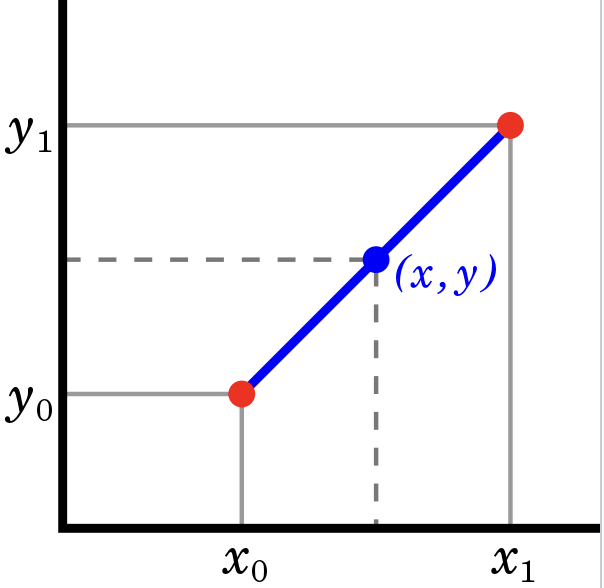

In [55]:
### 모든 칼럼의 데이터를 카운트로 보기
for i in range(len(concat.columns)):
    print(concat.columns[i], concat[concat.columns[i]].nunique())


시군구 339
전용면적 14670
계약년월 201
층 73
건축년도 60
도로명 9245
target 14531
is_test 2
index_num 1128094
구분 36371
구분date 661122
구분num 36371


### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

## 4 . Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

In [56]:
'''
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 4))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()
'''

"\n# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.\nfig = plt.figure(figsize=(13, 4))\nmissing = concat.isnull().sum() / concat.shape[0]\nmissing = missing[missing > 0]\nmissing.sort_values(inplace=True)\nmissing.plot.bar(color='orange')\nplt.title('변수별 결측치 비율')\nplt.show()\n"

- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [57]:
'''
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)
'''

'\n# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.\ncontinuous_columns = []\ncategorical_columns = []\n\nfor column in concat_select.columns:\n    if pd.api.types.is_numeric_dtype(concat_select[column]):\n        continuous_columns.append(column)\n    else:\n        categorical_columns.append(column)\n\nprint("연속형 변수:", continuous_columns)\nprint("범주형 변수:", categorical_columns)\n'

- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [58]:
'''
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)
'''

"\n# 범주형 변수에 대한 보간\nconcat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')\n\n# 연속형 변수에 대한 보간 (선형 보간)\nconcat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)\n"

In [59]:
# concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

- Baseline에서는 단순 결측치들을 제거하거나 보간했지만,
EDA를 통해 변수들의 흐름을 조금 더 파악하고 더 나은 interpolation(보간법) 등의 방법을 고려해볼 수 있을 것 같습니다.

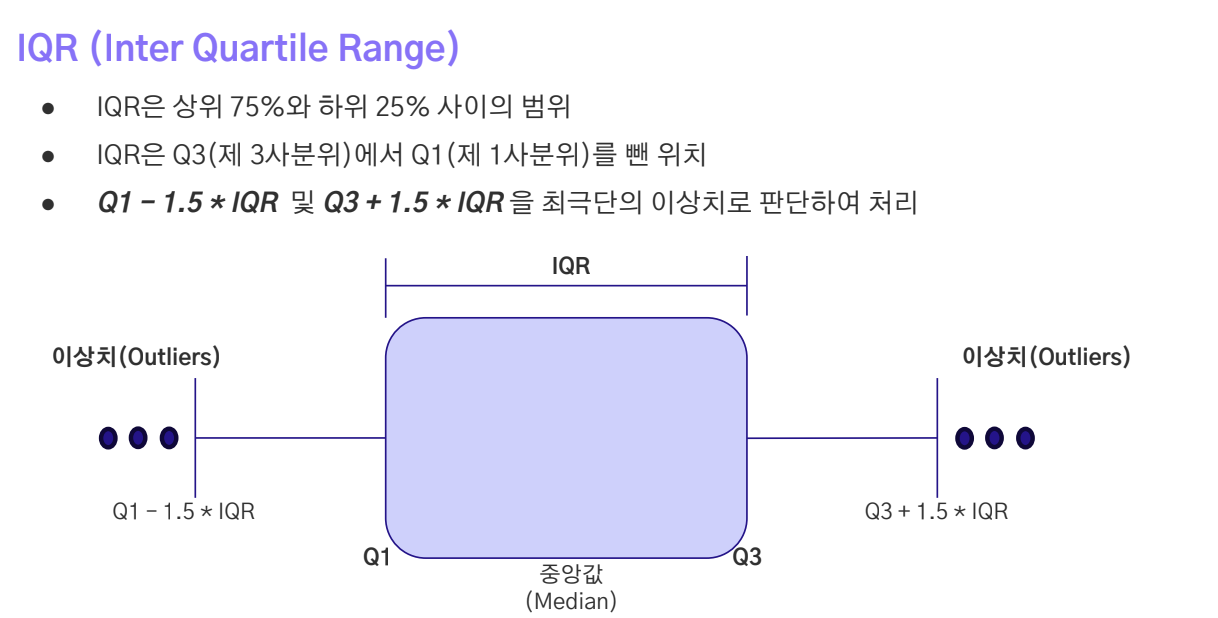

In [60]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat.shape)

(1128094, 12)


In [61]:
concat.describe()

,전용면적,계약년월,층,건축년도,target,is_test,index_num,구분num
count,1.128094e+06,1.128094e+06,1.128094e+06,1.128094e+06,1.128094e+06,1.128094e+06,1.128094e+06,1.128094e+06
mean,7.716028e+01,2.014829e+05,8.881412e+00,1.998791e+03,5.751489e+04,8.219173e-03,5.640465e+05,1.754935e+04
std,2.936448e+01,4.237691e+02,5.989302e+00,9.358540e+00,4.653036e+04,9.028635e-02,3.256528e+05,9.724563e+03
min,1.002000e+01,2.007010e+05,-4.000000e+00,1.961000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.965000e+01,2.011110e+05,4.000000e+00,1.992000e+03,3.000000e+04,0.000000e+00,2.820232e+05,1.049700e+04
50%,8.187000e+01,2.015080e+05,8.000000e+00,2.000000e+03,4.450000e+04,0.000000e+00,5.640465e+05,1.607400e+04
75%,8.496000e+01,2.018050e+05,1.200000e+01,2.005000e+03,6.950000e+04,0.000000e+00,8.460698e+05,2.550800e+04
max,4.243200e+02,2.023090e+05,6.900000e+01,2.023000e+03,1.450000e+06,1.000000e+00,1.128093e+06,3.637000e+04


In [62]:
concat[concat['전용면적'] > 135].count()

시군구          44127
전용면적         44127
계약년월         44127
층            44127
건축년도         44127
도로명          44127
target       44127
is_test      44127
index_num    44127
구분           44127
구분date       44127
구분num        44127
dtype: int64

In [63]:
a = concat.전용면적.value_counts()

In [64]:
a = pd.DataFrame(a).reset_index()

In [65]:
a.describe()

,전용면적,count
count,14670.000000,14670.000000
mean,94.880815,76.898023
std,53.532142,546.077378
min,10.020000,1.000000
25%,57.504975,3.000000
50%,84.619000,10.000000
75%,124.397500,33.000000
max,424.320000,20593.000000


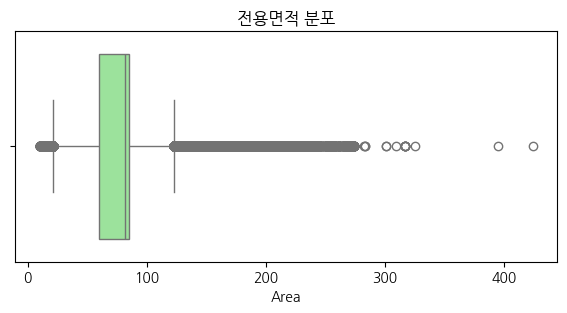

In [66]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [67]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [68]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat = remove_outliers_iqr(concat, '전용면적')

In [69]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat.shape)

(1038846, 12)


In [70]:
concat['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

is_test
0    1029574
1       9272
Name: count, dtype: int64

In [71]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat['구'] = concat['구분'].map(lambda x : x.split()[1])
concat['동'] = concat['구분'].map(lambda x : x.split()[2])
#del concat['시군구']

concat['계약년'] = concat['계약년월'].astype('str').map(lambda x : x[:4])
concat['계약월'] = concat['계약년월'].astype('str').map(lambda x : x[4:])
#del concat['계약년월']

In [72]:
len(concat.columns), concat.columns

(16,
 Index(['시군구', '전용면적', '계약년월', '층', '건축년도', '도로명', 'target', 'is_test',
        'index_num', '구분', '구분date', '구분num', '구', '동', '계약년', '계약월'],
       dtype='object'))

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [73]:
all = list(concat['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [74]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat['강남여부'] = is_gangnam

In [75]:
len(concat.columns), concat.columns

(17,
 Index(['시군구', '전용면적', '계약년월', '층', '건축년도', '도로명', 'target', 'is_test',
        'index_num', '구분', '구분date', '구분num', '구', '동', '계약년', '계약월', '강남여부'],
       dtype='object'))

In [76]:
concat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1038846 entries, 0 to 1128093
Data columns (total 17 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   시군구        1038846 non-null  object 
 1   전용면적       1038846 non-null  float64
 2   계약년월       1038846 non-null  int64  
 3   층          1038846 non-null  int64  
 4   건축년도       1038846 non-null  int64  
 5   도로명        1038846 non-null  object 
 6   target     1038846 non-null  int64  
 7   is_test    1038846 non-null  int64  
 8   index_num  1038846 non-null  int64  
 9   구분         1038846 non-null  object 
 10  구분date     1038846 non-null  object 
 11  구분num      1038846 non-null  int64  
 12  구          1038846 non-null  object 
 13  동          1038846 non-null  object 
 14  계약년        1038846 non-null  object 
 15  계약월        1038846 non-null  object 
 16  강남여부       1038846 non-null  int64  
dtypes: float64(1), int64(8), object(8)
memory usage: 142.7+ MB


- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [77]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    1.038846e+06
mean     1.998583e+03
std      9.132471e+00
min      1.961000e+03
10%      1.987000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.009000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

In [78]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
concat['신축여부'] = concat['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [79]:
concat.head(1)       # 최종 데이터셋은 아래와 같습니다.

,시군구,전용면적,계약년월,층,건축년도,도로명,target,is_test,index_num,구분,구분date,구분num,구,동,계약년,계약월,강남여부,신축여부
0,서울특별시 강남구 개포동,79.97,201712,3,1987,언주로 3,124000,0,0,서울특별시 강남구 개포동 658-1 개포6차우성 79.97,서울특별시 강남구 개포동 658-1 개포6차우성 79.97 201712,190,강남구,개포동,2017,12,1,0


- 위 두 사항 외에도 외부 공공 데이터를 이용하거나, EDA를 통해 더 많은 변수를 제작할 수 있습니다.

### 작성한 것.

#### 아파트별 구분 만들기

#### 아파트별에 평수를 '구분' 컬럼 추가하기

##### 아파트 거래량 확인

#### <font color=Tomato> 해보려는 것 1
- 아파트별 치수별로 연 월 단위로 평균값을 가진 그래프 만들기
- 아파트별 월별 시계열 결측치 채워넣기
- 시계열 관련 이동평균선과 가중이동평균선, 누적 레그만들기
- 타임 스플릿으로 데이터 쪼개로 모델 학습시키기
- 샘플링 결과 확인하기
</font>

#### <font color=Tomato> 해보려는 것 2
- <font color=Tomato>아파트별 치수별로 연 월 단위를 그래프로 점 찍어서 분포 보기
- 이 내용에 대해서 시계열로 된거 그냥 바로 예측시켜보기.

<font color=Tomato> 위 두가지 내용에 대해서 결과치에 대한 평가해보기



### 새로운 변수 만들기

[ ] 이동평균, 가중이동평균

[ ] 서울 평균, 구 평균, 동 평균 추가






In [80]:
len(concat)

1038846

In [81]:
### 아파트별 전용면적별 거래량

# 2500
A = [0]
i = 0
while i < 2200:
    i += 100
    A.append(i)

tmp = concat['구분'].value_counts().reset_index()
for i in A :
    tmp1 = tmp[tmp['count'] > i]
    #print(tmp1)
    print('계약건수 ', i, '건수 이상의 전체 합은 :', tmp1['count'].sum(), "건")


    ### 거래 건수별 평당 평균 거래가격은?

계약건수  0 건수 이상의 전체 합은 : 1038846 건
계약건수  100 건수 이상의 전체 합은 : 650791 건
계약건수  200 건수 이상의 전체 합은 : 437565 건
계약건수  300 건수 이상의 전체 합은 : 301903 건
계약건수  400 건수 이상의 전체 합은 : 221179 건
계약건수  500 건수 이상의 전체 합은 : 159797 건
계약건수  600 건수 이상의 전체 합은 : 114812 건
계약건수  700 건수 이상의 전체 합은 : 77299 건
계약건수  800 건수 이상의 전체 합은 : 54011 건
계약건수  900 건수 이상의 전체 합은 : 43156 건
계약건수  1000 건수 이상의 전체 합은 : 36713 건
계약건수  1100 건수 이상의 전체 합은 : 27442 건
계약건수  1200 건수 이상의 전체 합은 : 22885 건
계약건수  1300 건수 이상의 전체 합은 : 16674 건
계약건수  1400 건수 이상의 전체 합은 : 13929 건
계약건수  1500 건수 이상의 전체 합은 : 12503 건
계약건수  1600 건수 이상의 전체 합은 : 10924 건
계약건수  1700 건수 이상의 전체 합은 : 9313 건
계약건수  1800 건수 이상의 전체 합은 : 4117 건
계약건수  1900 건수 이상의 전체 합은 : 4117 건
계약건수  2000 건수 이상의 전체 합은 : 2168 건
계약건수  2100 건수 이상의 전체 합은 : 2168 건
계약건수  2200 건수 이상의 전체 합은 : 0 건


In [654]:
A = 50
B = 400

tmp = concat['구분'].value_counts().reset_index()
print(tmp)
print("-----------------------------------------------------------", A, "--------------------------")
tmp_50 = tmp[tmp['count'] > 200]
print(tmp_50)
print("-----------------------------------------------------------", B, "--------------------------")
tmp_400 = tmp[tmp['count'] > B]
print(tmp_400)

                                       구분  count
0             서울특별시 도봉구 도봉동 30-1 한신 84.94   2168
1             서울특별시 노원구 중계동 369 주공2 44.52   1949
2              서울특별시 송파구 잠실동 22 리센츠 84.99   1755
3            서울특별시 도봉구 창동 38 주공17단지 36.16   1722
4      서울특별시 강북구 미아동 1353 에스케이북한산시티 59.98   1719
...                                   ...    ...
30907      서울특별시 영등포구 양평동4가 196 수성예술 82.5      1
30908     서울특별시 영등포구 양평동4가 160-2 약산 34.58      1
30909     서울특별시 도봉구 방학동 690-3 부영팰리스 79.05      1
30910  서울특별시 송파구 가락동 77-7 송파Nsuite 112.57      1
30911        서울특별시 마포구 합정동 390-5 대운 58.16      1

[30912 rows x 2 columns]
----------------------------------------------------------- 50 --------------------------
                                      구분  count
0            서울특별시 도봉구 도봉동 30-1 한신 84.94   2168
1            서울특별시 노원구 중계동 369 주공2 44.52   1949
2             서울특별시 송파구 잠실동 22 리센츠 84.99   1755
3           서울특별시 도봉구 창동 38 주공17단지 36.16   1722
4     서울특별시 강북구 미아동 1353 에스케이북한산시티 59.98   1719
...     

### 1년전까지 가격 동 평균 평단 단가로 유추해서 집어넣는 코드 만들기

In [83]:
len(concat.columns),concat.columns

(18,
 Index(['시군구', '전용면적', '계약년월', '층', '건축년도', '도로명', 'target', 'is_test',
        'index_num', '구분', '구분date', '구분num', '구', '동', '계약년', '계약월', '강남여부',
        '신축여부'],
       dtype='object'))

In [84]:
base = concat.copy()

In [85]:
# base.drop(columns=['index_num', '구분date', '구분num'], inplace=True)

In [86]:
브레이크

NameError: name '브레이크' is not defined

In [ ]:
# base_mean = pd.read_csv('/content/drive/MyDrive/AILAB_Advance/base_mean.csv')
# base = pd.read_csv('/content/drive/MyDrive/AILAB_Advance/base.csv')


In [ ]:
# base.info()
# base2 =
base.iloc[0][0]

In [ ]:
base.isnull().sum()

In [ ]:
tmp = base[['구분', '구분date', '계약년월', 'mean']]
tmp[tmp['구분'] == '서울특별시 강남구 개포동 1164-12 새롬 73.5']


In [ ]:
### 테스트

da = tmp[tmp['구분'] == '서울특별시 강남구 개포동 1164-12 새롬 73.5']
df = pd.DataFrame(da)

# 202007부터 202207까지의 계약년월 필터링
filtered_df = df[(df['계약년월'] >= 202007) & (df['계약년월'] <= 202207)]

# 피벗 테이블 생성
pivot_table = filtered_df.pivot_table(index='구분', columns='계약년월', values='mean')

# 결과 출력
print("Pivoted Table:")
print(pivot_table)

In [ ]:
tmp[tmp['mean'] == 0]


In [ ]:
# 평균 0값이 있는 아파트 내용 보기
tmp[tmp['구분'] == '서울특별시 강남구 개포동 12 삼익대청 39.53']

In [ ]:
# 평균 0값이 있는 아파트 내용 보기
base[base['구분'] == '서울특별시 강남구 개포동 12 삼익대청 39.53']

In [ ]:
pivoted = tmp.pivot(index='구분', columns='계약년월', values='mean')

In [ ]:
pivoted

In [ ]:
# train_pivoted = concat.pivot(index='구분', columns='계약년월', values='target')

[    ] test 계약 분포 알아보기

In [ ]:
data.info()

In [ ]:
# 동 지역별
dong_grouped = concat.groupby('동').agg({
    '전용면적': 'sum',
    'target': ['sum', 'mean']
})

# 컬럼 이름 정리
dong_grouped.columns = ['전용면적_합', '타겟_합(동)', '타겟_평균(동)']

In [ ]:
dong_grouped['타겟_면적당_비율(동)'] = dong_grouped['타겟_합(동)'] / dong_grouped['전용면적_합']

In [ ]:
dong_grouped.head()

In [ ]:
dong_grouped.reset_index(inplace=True)

In [ ]:
merge_d = dong_grouped[['동','타겟_평균(동)','타겟_면적당_비율(동)']]
concat = pd.merge(concat, merge_d, on='동', how='left')

In [ ]:
# 아파트 면적당 평균가격 최근 3년

In [ ]:
concat.info()

In [ ]:
### 전체 평균값, 지역 평균값 만들기
# df_all['national_avg'] = df_all.groupby(['year','month'])['microbusiness_density'].transform('mean')
# df_all['state_avg'] = df_all.groupby(['state','year','month'])['microbusiness_density'].transform('mean')

### 샘플링 데이터 - 구분(아파트+면적)별 시계열 데이터 분석

In [ ]:
concat.columns

In [ ]:
tran_count = concat['구분'].value_counts()
tran_count = pd.DataFrame(tran_count).reset_index()
tran_count

In [3023]:
tmp = concat['구분'].value_counts().reset_index()
#print(tmp)
print("-----------------------------------------------------------", A, "--------------------------")
tmp_50 = tmp[tmp['count'] > 9]
print(tmp_50.tail(10))
#print("-----------------------------------------------------------", B, "--------------------------")
#tmp_400 = tmp[tmp['count'] > B]
#print(tmp_400)

----------------------------------------------------------- 50 --------------------------
                                        구분  count
12491       서울특별시 송파구 문정동 68-15 예그리나 82.72     10
12492  서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676     10
12493  서울특별시 성동구 성수동2가 279-50 성수1차대우 84.51     10
12494     서울특별시 성동구 성수동2가 609-2 강변임광 84.69     10
12495      서울특별시 마포구 망원동 456-9 길명1차 109.61     10
12496         서울특별시 성북구 정릉동 822-1 대원 81.17     10
12497    서울특별시 동대문구 이문동 425 이문삼성래미안 84.991     10
12498      서울특별시 마포구 망원동 495 신부3차파스카 59.94     10
12499           서울특별시 도봉구 쌍문동 54 현대1 63.36     10
12500        서울특별시 양천구 신정동 916-15 심미 81.88     10


In [3100]:
### 샘플링용 데이터 만들기
#
NUM = 12492
sample = concat.loc[ concat['구분'] == tran_count.iloc[NUM][0] ]

title = tran_count.iloc[NUM][0]
### 내용확인
print(title, "의 ", len(sample), '건의 매매 데이터 분석\n')
sample.info()

서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 의  10 건의 매매 데이터 분석

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 85839 to 751401
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   시군구        10 non-null     object 
 1   전용면적       10 non-null     float64
 2   계약년월       10 non-null     int64  
 3   층          10 non-null     int64  
 4   건축년도       10 non-null     int64  
 5   도로명        10 non-null     object 
 6   target     10 non-null     int64  
 7   is_test    10 non-null     int64  
 8   index_num  10 non-null     int64  
 9   구분         10 non-null     object 
 10  구분date     10 non-null     object 
 11  구분num      10 non-null     int64  
 12  구          10 non-null     object 
 13  동          10 non-null     object 
 14  계약년        10 non-null     object 
 15  계약월        10 non-null     object 
 16  강남여부       10 non-null     int64  
 17  신축여부       10 non-null     int64  
dtypes: float64(1), int64(9), object(8

In [3101]:
### 계약년월을 int값으로 변경, 시계열 전환을 위해
sample['계약년월'] = sample['계약년월'].astype(int)

### 데이터 정렬: '구분date'로 '계약년월' 순서로 정렬
final_data = sample.sort_values(by=['구분date'])

### 정렬 변경내용 확인
final_data[['구분date', '계약년월', 'target']].head(10)

,구분date,계약년월,target
131848,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201111,201111,98000
751399,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201410,201410,88000
751401,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201504,201504,84500
635882,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201510,201510,94000
534684,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201701,201701,90000
534688,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201705,201705,99000
534689,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201706,201706,93700
85839,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201802,201802,110000
380417,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 202006,202006,158000
221254,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 202306,202306,163500


In [3102]:
# IQR 방법을 사용하여 이상치 제거하는 함수
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


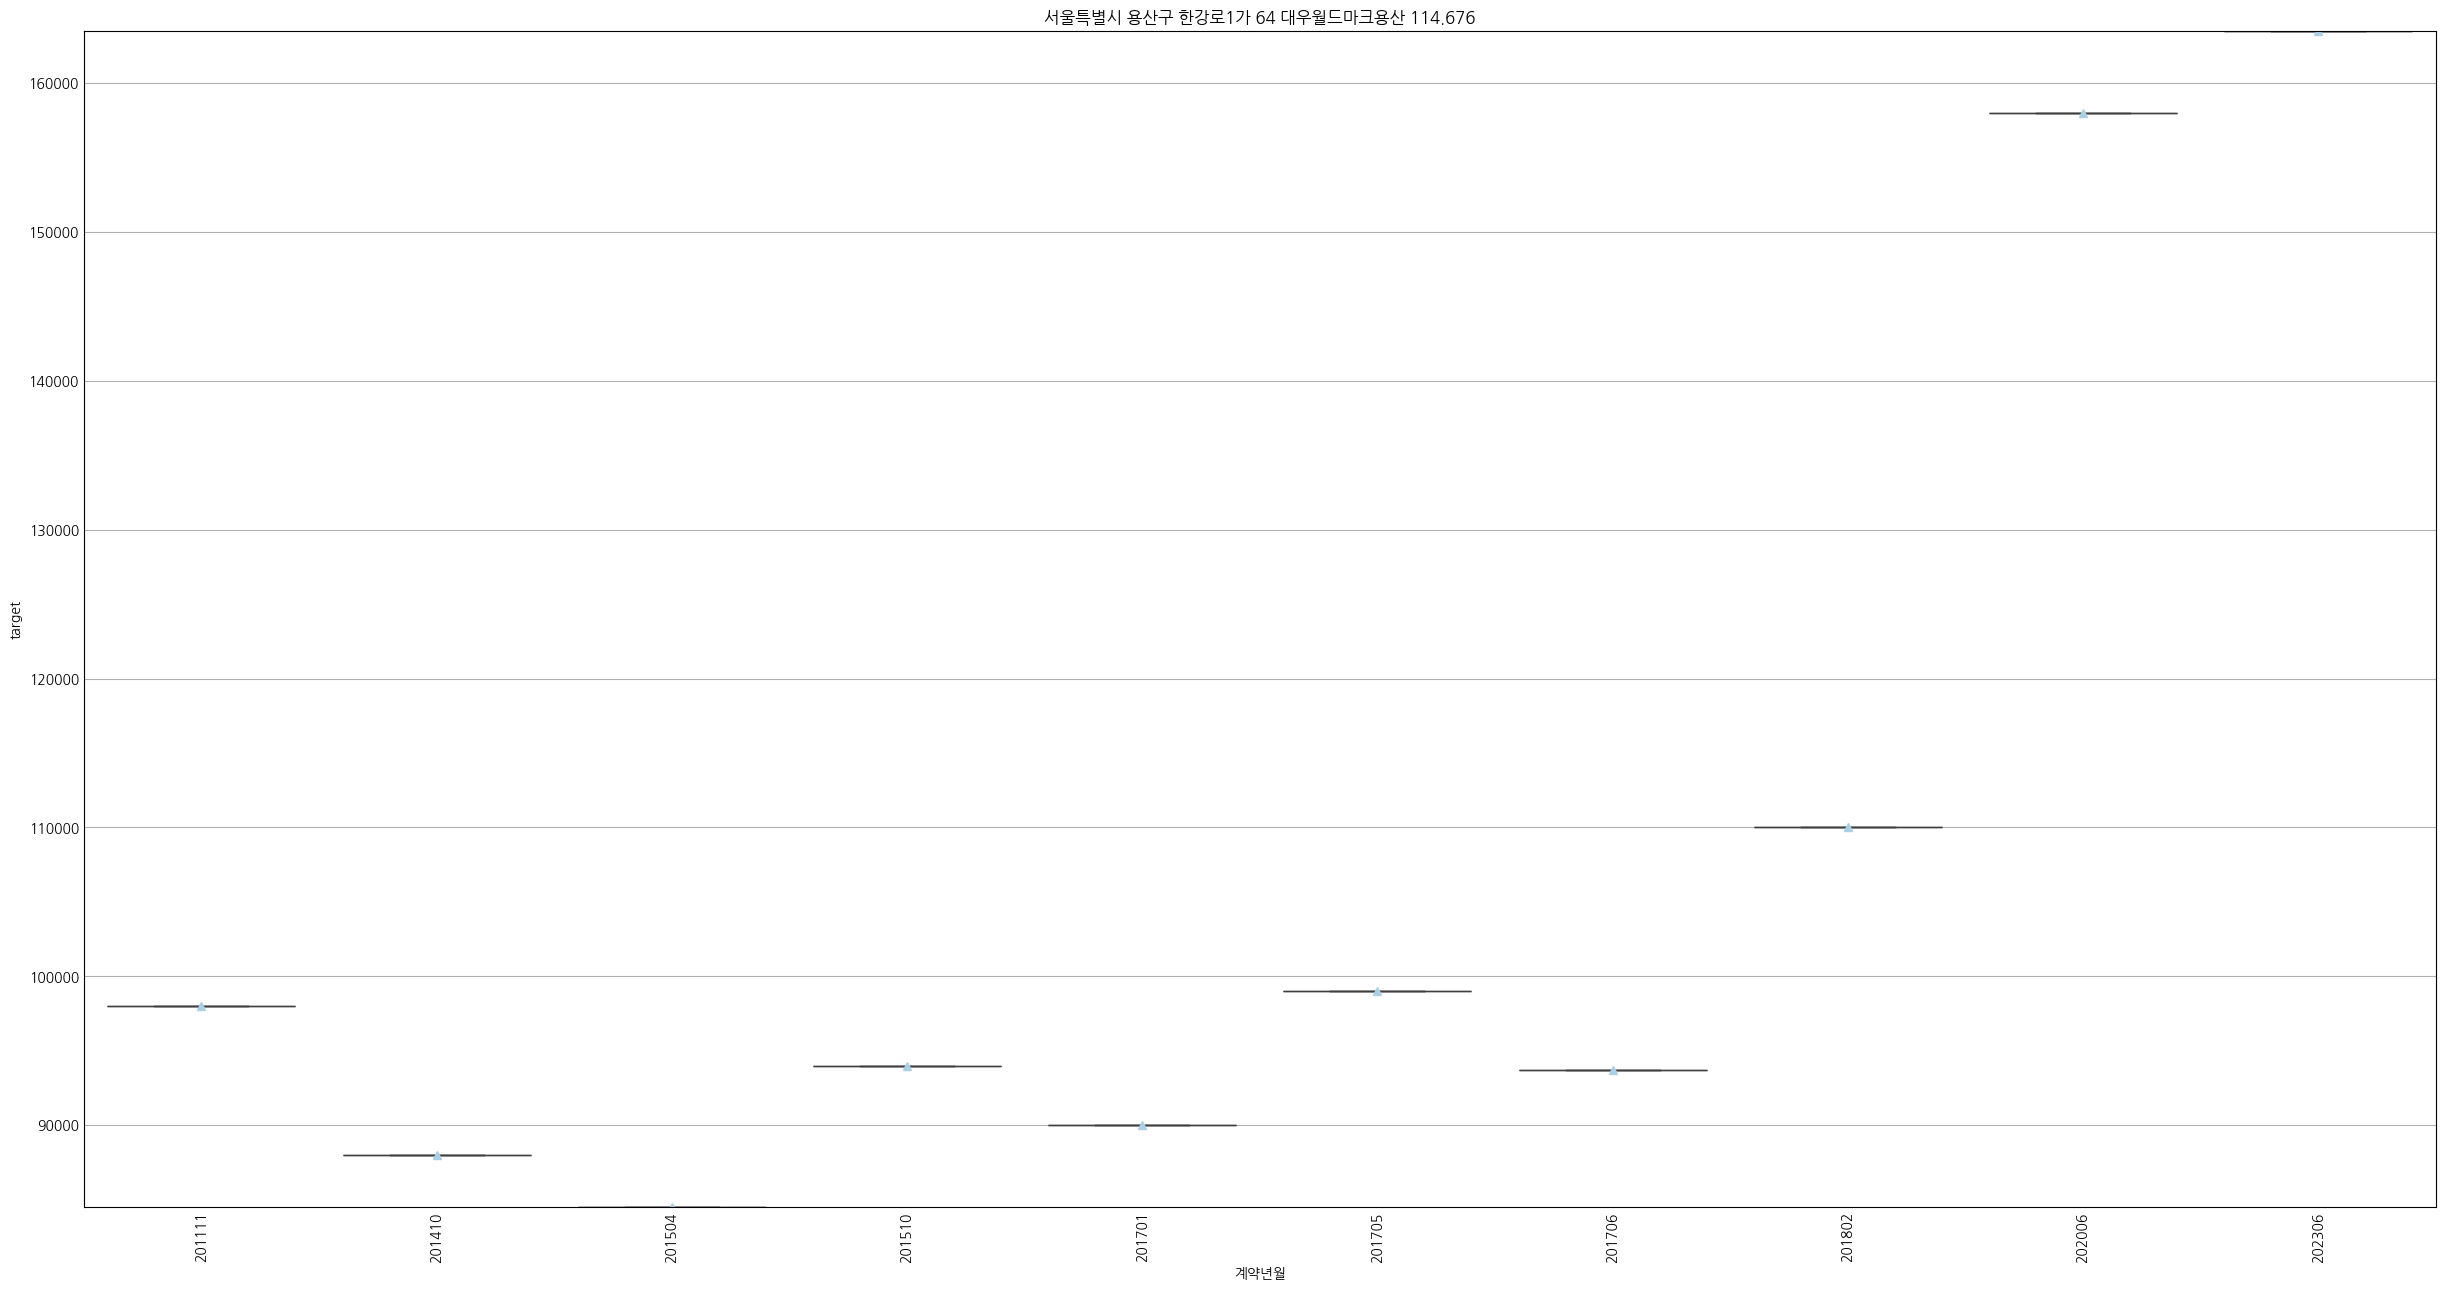

In [3103]:
### 이상치 제거전 확인 박스그래프
plt.style.use('_mpl-gallery')
figure = plt.figure(figsize=(24, 12))
plt.title(title)

plt.ylim(final_data['target'].min(),final_data['target'].max())
plt.xticks(rotation=90)
sns.boxplot(x="계약년월", y="target", data=final_data, showmeans=True)

plt.show()

In [3104]:
### 각 계약년월별로 이상치 제거 후 평균 계산
data_cleaned = final_data.groupby('구분date').apply(lambda x: remove_outliers(x, 'target'))
data_cleaned = data_cleaned.reset_index(drop=True)

In [3105]:
### n 개 이상치가 제거됨
LEN1 = len(final_data)
LEN2 = len(data_cleaned)
LEN1, LEN2, len(final_data)-len(data_cleaned)

(10, 10, 0)

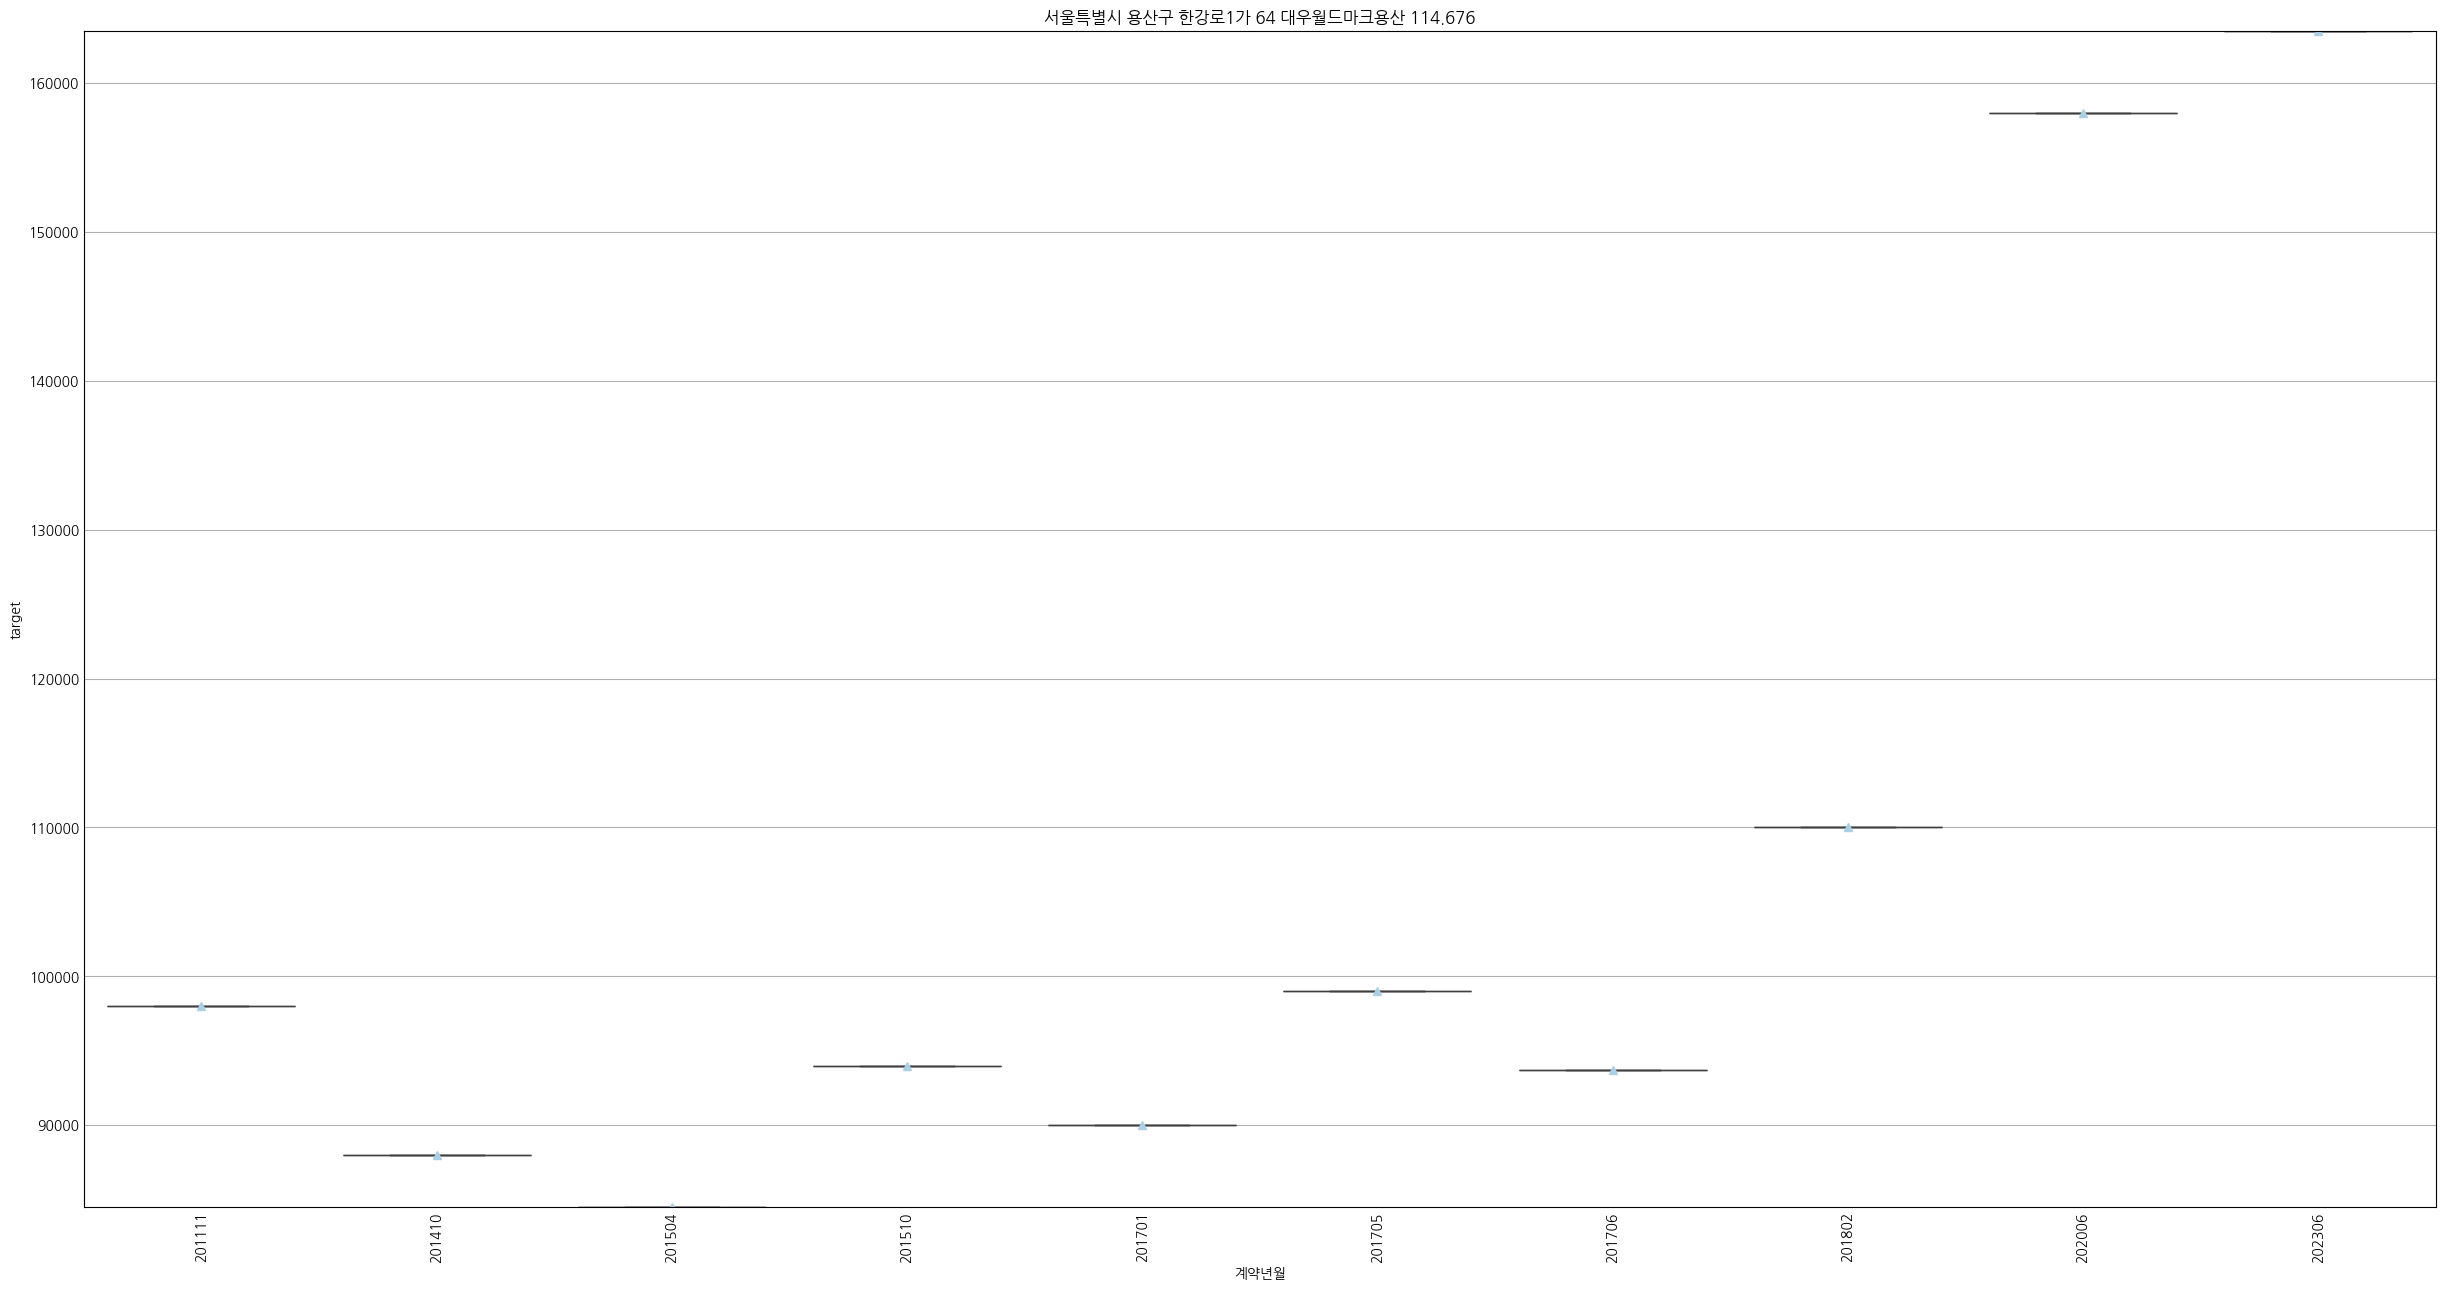

In [3106]:
### 이상치 제거후 확인 박스그래프
plt.style.use('_mpl-gallery')
figure = plt.figure(figsize=(24, 12))
plt.title(title)

plt.ylim(final_data['target'].min(),final_data['target'].max())
plt.xticks(rotation=90)
sns.boxplot(x="계약년월", y="target", data=data_cleaned, showmeans=True)

plt.show()

In [3107]:
### 변경내용 확인
data_cleaned[['구분date', '계약년월', 'target']].head(10)

,구분date,계약년월,target
0,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201111,201111,98000
1,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201410,201410,88000
2,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201504,201504,84500
3,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201510,201510,94000
4,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201701,201701,90000
5,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201705,201705,99000
6,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201706,201706,93700
7,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201802,201802,110000
8,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 202006,202006,158000
9,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 202306,202306,163500


In [3108]:
### 계약년월 별 target의 평균값 계산
mean_target = data_cleaned.groupby('구분date')['target'].mean().reset_index()
mean_target.columns = ['구분date', 'mean']

mean_target.head()

,구분date,mean
0,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201111,98000.0
1,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201410,88000.0
2,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201504,84500.0
3,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201510,94000.0
4,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201701,90000.0


In [3109]:
### 이동평균과 지수이동평균을 구하는 함수입니다.
### SMA와 EMA는 모두 일반적으로 사용되는 추세 지표입니다. SMA는 모든 데이터 포인트에 동일한 가중치를 부여하는 반면, EMA는 최근 데이터 포인트에 더 많은 가중치를 부여합니다.

def moving_average(df,i, n):
    MA = pd.Series(df[i].rolling(n, min_periods=n).mean(), name = 'MA_' + str(n))
    df = df.join(MA)
    return df

def weighted_moving_average(df,i, n):
    EMA = pd.Series(df[i].ewm(span=n, adjust=False, min_periods=n).mean(), name = 'EMA_' + str(n))
    df = df.join(EMA)
    return df

In [3110]:
### 변수를 생성
df_all = mean_target

# 시간 시계열 기반 변수를 생성합니다.
# 이동 평균(Moving Average) 변수를 생성합니다.
df_all = moving_average(df_all, 'mean', 3)
df_all = moving_average(df_all, 'mean', 6)

# 지수 이동 평균(Exponential Moving Average) 변수를 생성합니다.
df_all = weighted_moving_average(df_all, 'mean', 3)
df_all = weighted_moving_average(df_all, 'mean', 6)

In [3111]:
### 생성변수 확인
df_all[['구분date','mean', 'MA_3', 'MA_6', 'EMA_3','EMA_6']].head(10)

,구분date,mean,MA_3,MA_6,EMA_3,EMA_6
0,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201111,98000.0,NaN,NaN,NaN,NaN
1,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201410,88000.0,NaN,NaN,NaN,NaN
2,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201504,84500.0,90166.666667,NaN,88750.000000,NaN
3,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201510,94000.0,88833.333333,NaN,91375.000000,NaN
4,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201701,90000.0,89500.000000,NaN,90687.500000,NaN
5,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201705,99000.0,94333.333333,92250.000000,94843.750000,93920.568811
6,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201706,93700.0,94233.333333,91533.333333,94271.875000,93857.549150
7,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201802,110000.0,100900.000000,95200.000000,102135.937500,98469.677965
8,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 202006,158000.0,120566.666667,107450.000000,130067.968750,115478.341403
9,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 202306,163500.0,143833.333333,119033.333333,146783.984375,129198.815288


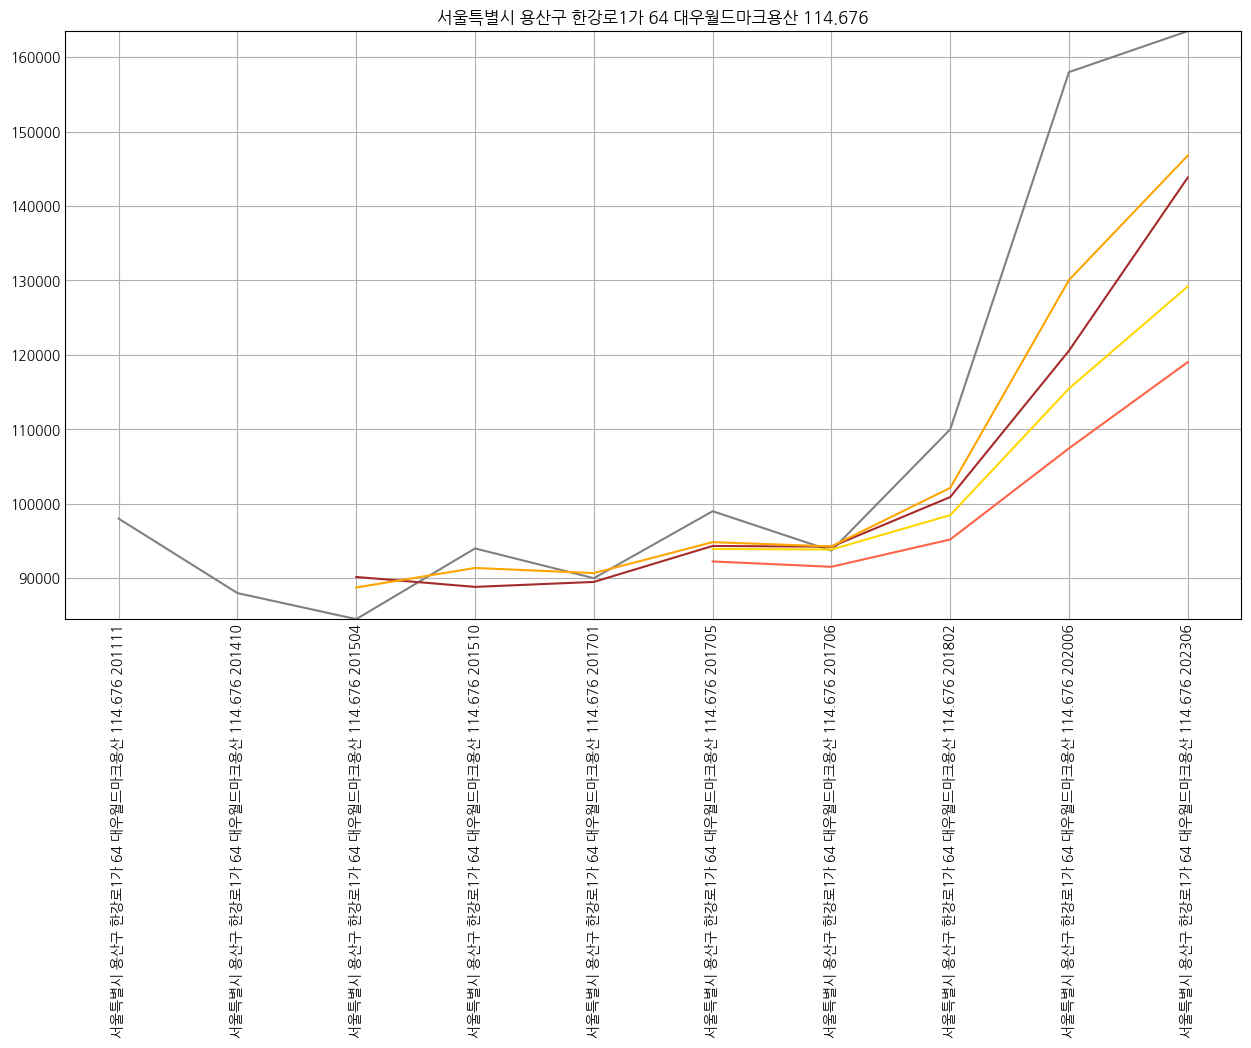

In [3112]:
plt.style.use('_mpl-gallery')
figure = plt.figure(figsize=(12, 6))
plt.title(title)

plt.plot(df_all['구분date'], df_all['mean'], color='gray')
plt.plot(df_all['구분date'], df_all['MA_3'], color='brown')
plt.plot(df_all['구분date'], df_all['MA_6'], color='tomato')
plt.plot(df_all['구분date'], df_all['EMA_3'], color='orange')
plt.plot(df_all['구분date'], df_all['EMA_6'], color='gold')

plt.ylim(final_data['target'].min(),final_data['target'].max())
plt.xticks(rotation=90)


plt.show()

In [3113]:
### 변화율 추가
# add 'pct_change_before' variable. This variable shows that how the density changed previous month.
df_all['pct_change_before'] = df_all['mean'].pct_change().shift(1)

In [3114]:
df_all

,구분date,mean,MA_3,MA_6,EMA_3,EMA_6,pct_change_before
0,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201111,98000.0,NaN,NaN,NaN,NaN,NaN
1,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201410,88000.0,NaN,NaN,NaN,NaN,NaN
2,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201504,84500.0,90166.666667,NaN,88750.000000,NaN,-0.102041
3,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201510,94000.0,88833.333333,NaN,91375.000000,NaN,-0.039773
4,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201701,90000.0,89500.000000,NaN,90687.500000,NaN,0.112426
5,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201705,99000.0,94333.333333,92250.000000,94843.750000,93920.568811,-0.042553
6,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201706,93700.0,94233.333333,91533.333333,94271.875000,93857.549150,0.100000
7,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201802,110000.0,100900.000000,95200.000000,102135.937500,98469.677965,-0.053535
8,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 202006,158000.0,120566.666667,107450.000000,130067.968750,115478.341403,0.173959
9,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 202306,163500.0,143833.333333,119033.333333,146783.984375,129198.815288,0.436364


In [3115]:
### 레그값 추가

# gnerate lag date

def lag_feature(df, value):
    for lag in range(1, value):
        df[f'lag_mean_{lag}'] = df['mean'].shift(lag)
        df[f'lag_mean_{lag}'] = df[f'lag_mean_{lag}'].bfill()

    return df

df_all = lag_feature(df_all, 6)


In [3116]:
# 결과 확인
df_all.head()

,구분date,mean,MA_3,MA_6,EMA_3,EMA_6,pct_change_before,lag_mean_1,lag_mean_2,lag_mean_3,lag_mean_4,lag_mean_5
0,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201111,98000.0,NaN,NaN,NaN,NaN,NaN,98000.0,98000.0,98000.0,98000.0,98000.0
1,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201410,88000.0,NaN,NaN,NaN,NaN,NaN,98000.0,98000.0,98000.0,98000.0,98000.0
2,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201504,84500.0,90166.666667,NaN,88750.0,NaN,-0.102041,88000.0,98000.0,98000.0,98000.0,98000.0
3,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201510,94000.0,88833.333333,NaN,91375.0,NaN,-0.039773,84500.0,88000.0,98000.0,98000.0,98000.0
4,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 201701,90000.0,89500.000000,NaN,90687.5,NaN,0.112426,94000.0,84500.0,88000.0,98000.0,98000.0


In [3117]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 131848 to 221254
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   시군구        10 non-null     object 
 1   전용면적       10 non-null     float64
 2   계약년월       10 non-null     int64  
 3   층          10 non-null     int64  
 4   건축년도       10 non-null     int64  
 5   도로명        10 non-null     object 
 6   target     10 non-null     int64  
 7   is_test    10 non-null     int64  
 8   index_num  10 non-null     int64  
 9   구분         10 non-null     object 
 10  구분date     10 non-null     object 
 11  구분num      10 non-null     int64  
 12  구          10 non-null     object 
 13  동          10 non-null     object 
 14  계약년        10 non-null     object 
 15  계약월        10 non-null     object 
 16  강남여부       10 non-null     int64  
 17  신축여부       10 non-null     int64  
dtypes: float64(1), int64(9), object(8)
memory usage: 1.5+ KB


In [3118]:
# 원래 데이터에 새로만든 변수 추가
final_data = pd.merge(data_cleaned, df_all, on='구분date', how='left')


In [3119]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   시군구                10 non-null     object 
 1   전용면적               10 non-null     float64
 2   계약년월               10 non-null     int64  
 3   층                  10 non-null     int64  
 4   건축년도               10 non-null     int64  
 5   도로명                10 non-null     object 
 6   target             10 non-null     int64  
 7   is_test            10 non-null     int64  
 8   index_num          10 non-null     int64  
 9   구분                 10 non-null     object 
 10  구분date             10 non-null     object 
 11  구분num              10 non-null     int64  
 12  구                  10 non-null     object 
 13  동                  10 non-null     object 
 14  계약년                10 non-null     object 
 15  계약월                10 non-null     object 
 16  강남여부               10 non-nul

#### 계속

In [3120]:
### 함수로 만들기
def add_lag_feature(data): # df = 아파트별 데이터,
    data['계약년월'] = data['계약년월'].astype(int)
    final_data = data.sort_values(by=['구분date'])

    ### 각 계약년월별로 이상치 제거 후 평균 계산
    data_cleaned = final_data.groupby('구분date').apply(lambda x: remove_outliers(x, 'target'))
    data_cleaned = data_cleaned.reset_index(drop=True)

    mean_target = data_cleaned.groupby('구분date')['target'].mean().reset_index()
    mean_target.columns = ['구분date', 'mean']

    df_all = mean_target

    # 시간 시계열 기반 변수를 생성합니다.
    # 이동 평균(Moving Average) 변수를 생성합니다.
    df_all = moving_average(df_all, 'mean', 3)
    df_all = moving_average(df_all, 'mean', 6)

    # 지수 이동 평균(Exponential Moving Average) 변수를 생성합니다.
    df_all = weighted_moving_average(df_all, 'mean', 3)
    df_all = weighted_moving_average(df_all, 'mean', 6)

    df_all = lag_feature(df_all, 6)

    final_data = pd.merge(data_cleaned, df_all, on='구분date', how='left')

    return final_data

In [3121]:
# final_data.info()

In [3122]:
final_data['구분num'].value_counts()

구분num
30861    10
Name: count, dtype: int64

In [3123]:
#브레이크
%%time
###
# 12200	'서울특별시 도봉구 도봉동 30-1 한신 84.94'
# 전체 아파트 개수 30912
END = 30911
z = 0
#base = add_lag_feature(data.loc[data['구분num'] == 0])

for i in range(1, z):
    tmp = add_lag_feature(data.loc[data['구분num'] == i])
    print(end="\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b")

    # 데이터프레임 결합
    base = pd.concat([base, tmp], ignore_index=True)
    print("i:", i, "   tmp count:", len(tmp), "   base count:",len(base))


# 2시간 13분 12초 걸림
# Wall time: 2h 12min 12s 2024 07 17
#display(base)

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 11.9 µs


#### base 불러오기

In [3124]:
#저장하기# base.to_csv('/content/drive/MyDrive/AILAB_Advance/base.csv', index=False)

In [3125]:
# base = pd.read_csv('/content/drive/MyDrive/AILAB_Advance/base.csv')

In [3126]:
# base.info()

In [3127]:
# base.columns

In [3128]:
### mean 값만 추려서 파일 만들어서 전달
# base = base.sort_values(by=['recover_num'])
# base_mean=base[['구분date', 'recover_num', 'mean']]
# base_mean.to_csv('/content/drive/MyDrive/AILAB_Advance/base_mean.csv', index=False)

#base[base['is_test']==1]['mean']

In [3129]:
# base = base.sort_values(by=['recover_num'])

In [3130]:
### 데이터 순서 값 merge 시키기
#base2 = pd.merge(base, concat_select[['recover_num']], on='index', how='left')

In [3131]:
# len(base)

In [3132]:
# base.head()

In [3133]:
# display(base)

<font color=tomato>#### 거래년별로 거래량 확인해보기
전체 거래량 분의 최근 1년 거래량, 3년 거래량 5년 거래량


## 5 . Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

**<font color='gold'> 여기서부터 자동**

In [3134]:
###데이터 선택
#
# before_data = base
#
before_data = final_data.copy()

In [3135]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   시군구                10 non-null     object 
 1   전용면적               10 non-null     float64
 2   계약년월               10 non-null     int64  
 3   층                  10 non-null     int64  
 4   건축년도               10 non-null     int64  
 5   도로명                10 non-null     object 
 6   target             10 non-null     int64  
 7   is_test            10 non-null     int64  
 8   index_num          10 non-null     int64  
 9   구분                 10 non-null     object 
 10  구분date             10 non-null     object 
 11  구분num              10 non-null     int64  
 12  구                  10 non-null     object 
 13  동                  10 non-null     object 
 14  계약년                10 non-null     object 
 15  계약월                10 non-null     object 
 16  강남여부               10 non-nul

In [3136]:
before_data.drop(columns=['index_num', '구분date', '구분num'], inplace=True)

In [3137]:
sorted_data = before_data

In [3138]:
### base로 데이터 변경
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = sorted_data.query('is_test==0')
dt_test = sorted_data.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(10, 25) (0, 25)


In [3139]:
dt_test.isna().sum()

시군구                  0.0
전용면적                 0.0
계약년월                 0.0
층                    0.0
건축년도                 0.0
도로명                  0.0
target               0.0
구분                   0.0
구                    0.0
동                    0.0
계약년                  0.0
계약월                  0.0
강남여부                 0.0
신축여부                 0.0
mean                 0.0
MA_3                 0.0
MA_6                 0.0
EMA_3                0.0
EMA_6                0.0
pct_change_before    0.0
lag_mean_1           0.0
lag_mean_2           0.0
lag_mean_3           0.0
lag_mean_4           0.0
lag_mean_5           0.0
dtype: float64

In [3140]:
dt_test.head(1)

,시군구,전용면적,계약년월,층,건축년도,도로명,target,구분,구,동,계약년,계약월,강남여부,신축여부,mean,MA_3,MA_6,EMA_3,EMA_6,pct_change_before,lag_mean_1,lag_mean_2,lag_mean_3,lag_mean_4,lag_mean_5


In [3141]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

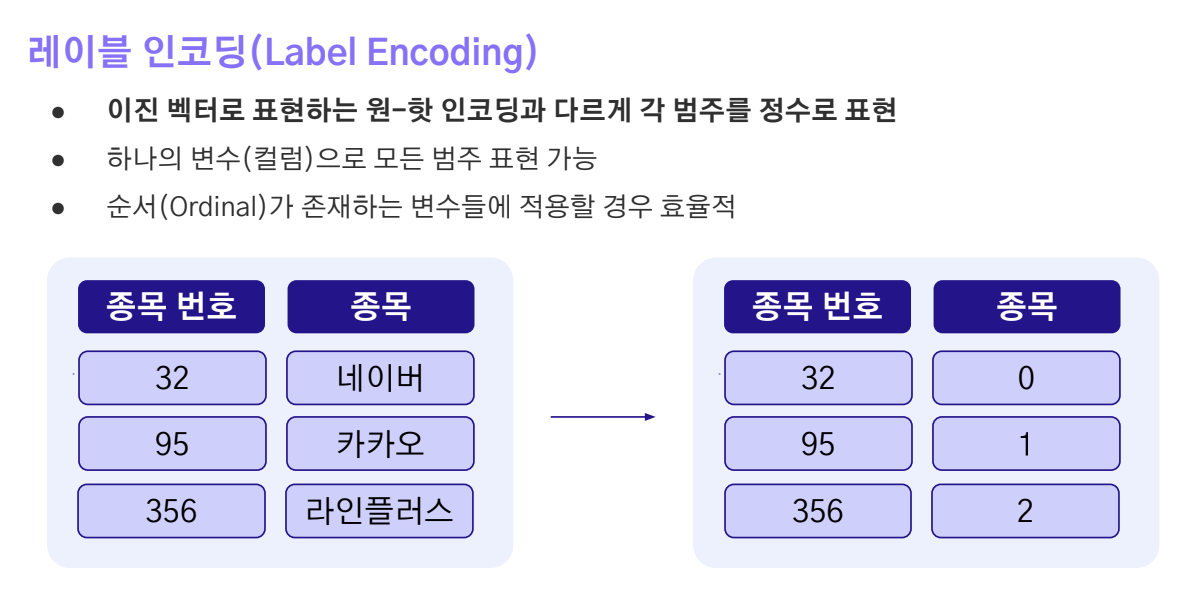

In [3142]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약년월', '층', '건축년도', 'target', '강남여부', '신축여부', 'mean', 'MA_3', 'MA_6', 'EMA_3', 'EMA_6', 'pct_change_before', 'lag_mean_1', 'lag_mean_2', 'lag_mean_3', 'lag_mean_4', 'lag_mean_5']
범주형 변수: ['시군구', '도로명', '구분', '구', '동', '계약년', '계약월']


In [3143]:
### 아래 레이블인코딩 8분2초 걸림

In [3144]:
%%time
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 7/7 [00:00<00:00, 537.35it/s]

CPU times: user 18.3 ms, sys: 1.94 ms, total: 20.2 ms
Wall time: 21.3 ms


In [3145]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,시군구,전용면적,계약년월,층,건축년도,도로명,target,구분,구,동,계약년,계약월,강남여부,신축여부,mean,MA_3,MA_6,EMA_3,EMA_6,pct_change_before,lag_mean_1,lag_mean_2,lag_mean_3,lag_mean_4,lag_mean_5
0,0,114.676,201111,21,2007,0,98000,0,0,0,0,6,0,0,98000.0,NaN,NaN,NaN,NaN,NaN,98000.0,98000.0,98000.0,98000.0,98000.0


In [3146]:
### 내용보기
dt_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 0 to 9
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   시군구                10 non-null     int64  
 1   전용면적               10 non-null     float64
 2   계약년월               10 non-null     int64  
 3   층                  10 non-null     int64  
 4   건축년도               10 non-null     int64  
 5   도로명                10 non-null     int64  
 6   target             10 non-null     int64  
 7   구분                 10 non-null     int64  
 8   구                  10 non-null     int64  
 9   동                  10 non-null     int64  
 10  계약년                10 non-null     int64  
 11  계약월                10 non-null     int64  
 12  강남여부               10 non-null     int64  
 13  신축여부               10 non-null     int64  
 14  mean               10 non-null     float64
 15  MA_3               8 non-null      float64
 16  MA_6               5 non-null     

### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 RandomForest를 이용하겠습니다.
- Train과 Valid dataset을 분할하는 과정에서는 `holdout` 방법을 사용하겠습니다. 이 방법의 경우  대략적인 성능을 빠르게 확인할 수 있다는 점에서 baseline에서 사용해보도록 하겠습니다.
  - 이 후 추가적인 eda를 통해서 평가세트와 경향을 맞추거나 kfold와 같은 분포에 대한 고려를 추가할 수 있습니다.

In [3147]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [3148]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [3149]:
X_train.fillna(method='bfill', inplace=True)
X_train.fillna(method='ffill', inplace=True)
X_val.fillna(method='bfill', inplace=True)
X_val.fillna(method='ffill', inplace=True)

y_train.fillna(method='bfill', inplace=True)
y_train.fillna(method='ffill', inplace=True)
y_val.fillna(method='bfill', inplace=True)
y_val.fillna(method='ffill', inplace=True)

In [3150]:
%%time
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
### 전체 4분걸림
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

CPU times: user 30 ms, sys: 93 µs, total: 30.1 ms
Wall time: 41.5 ms


- 랜덤포레스트의 하이퍼파라미터도 데이터에 맞게 지정해줄 수 있습니다. 데이터에 맞는 하이퍼파라미터를 찾는 것도 성능 향상에 도움이 될 수 있습니다.

In [3151]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.

# 전체에 대해 RMSE test: 2262.0626330912496

R = f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}'
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 22368.392879239225


###### baseline - RMSE test: 5851.882141463051




```
<class 'pandas.core.frame.DataFrame'>
Index: 1038846 entries, 0 to 9271
Data columns (total 49 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   번지                      1038846 non-null  object
 1   본번                      1038846 non-null  object
 2   부번                      1038846 non-null  object
 3   아파트명                    1038846 non-null  object
 4   전용면적                    1038846 non-null  float64
 5   계약일                     1038846 non-null  int64  
 6   층                       1038846 non-null  int64  
 7   건축년도                    1038846 non-null  int64  
 8   도로명                     1038846 non-null  object
 9   k-단지분류(아파트,주상복합등등)      1038846 non-null  object
 10  k-전화번호                  1038846 non-null  object
 11  k-팩스번호                  1038846 non-null  object
 12  k-세대타입(분양형태)            1038846 non-null  object
 13  k-관리방식                  1038846 non-null  object
 14  k-복도유형                  1038846 non-null  object
 15  k-난방방식                  1038846 non-null  object
 16  k-전체동수                  1038846 non-null  float64
 17  k-전체세대수                 1038846 non-null  float64
 18  k-건설사(시공사)              1038846 non-null  object
 19  k-시행사                   1038846 non-null  object
 20  k-사용검사일-사용승인일           1038846 non-null  object
 21  k-연면적                   1038846 non-null  float64
 22  k-주거전용면적                1038846 non-null  float64
 23  k-관리비부과면적               1038846 non-null  float64
 24  k-전용면적별세대현황(60㎡이하)      1038846 non-null  float64
 25  k-전용면적별세대현황(60㎡~85㎡이하)  1038846 non-null  float64
 26  k-85㎡~135㎡이하            1038846 non-null  float64
 27  k-수정일자                  1038846 non-null  object
 28  고용보험관리번호                1038846 non-null  object
 29  경비비관리형태                 1038846 non-null  object
 30  세대전기계약방법                1038846 non-null  object
 31  청소비관리형태                 1038846 non-null  object
 32  건축면적                    1038846 non-null  float64
 33  주차대수                    1038846 non-null  float64
 34  기타/의무/임대/임의=1/2/3/4     1038846 non-null  object
 35  단지승인일                   1038846 non-null  object
 36  사용허가여부                  1038846 non-null  object
 37  관리비 업로드                 1038846 non-null  object
 38  좌표X                     1038846 non-null  float64
 39  좌표Y                     1038846 non-null  float64
 40  단지신청일                   1038846 non-null  object
 41  target                  1038846 non-null  float64
 42  is_test                 1038846 non-null  int64  
 43  구                       1038846 non-null  object
 44  동                       1038846 non-null  object
 45  계약년                     1038846 non-null  object
 46  계약월                     1038846 non-null  object
 47  강남여부                    1038846 non-null  int64  
 48  신축여부                    1038846 non-null  int64  
dtypes: float64(14), int64(6), object(29)
memory usage: 396.3+ MB```



###### base - RMSE test: 5708.848177198493


```
<class 'pandas.core.frame.DataFrame'>
Index: 1038846 entries, 0 to 1128093
Data columns (total 15 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   시군구      1038846 non-null  object
 1   전용면적     1038846 non-null  float64
 2   계약년월     1038846 non-null  int64  
 3   층        1038846 non-null  int64  
 4   건축년도     1038846 non-null  int64  
 5   도로명      1038846 non-null  object
 6   target   1038846 non-null  int64  
 7   is_test  1038846 non-null  int64  
 8   구분       1038846 non-null  object
 9   구        1038846 non-null  object
 10  동        1038846 non-null  object
 11  계약년      1038846 non-null  object
 12  계약월      1038846 non-null  object
 13  강남여부     1038846 non-null  int64  
 14  신축여부     1038846 non-null  int64  
dtypes: float64(1), int64(7), object(7)
memory usage: 126.8+ MB
```



###### sample1 - RMSE test: 1956.034578860734
서울특별시 도봉구 도봉동 30-1 한신 84.94	- 2100개

```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   시군구                2100 non-null   object
 1   전용면적               2100 non-null   float64
 2   계약년월               2100 non-null   int64  
 3   층                  2100 non-null   int64  
 4   건축년도               2100 non-null   int64  
 5   도로명                2100 non-null   object
 6   target             2100 non-null   int64  
 7   is_test            2100 non-null   int64  
 8   index_num          2100 non-null   int64  
 9   구분                 2100 non-null   object
 10  구분date             2100 non-null   object
 11  구분num              2100 non-null   int64  
 12  구                  2100 non-null   object
 13  동                  2100 non-null   object
 14  계약년                2100 non-null   object
 15  계약월                2100 non-null   object
 16  강남여부               2100 non-null   int64  
 17  신축여부               2100 non-null   int64  
 18  mean               2100 non-null   float64
 19  MA_3               2091 non-null   float64
 20  MA_6               2075 non-null   float64
 21  EMA_3              2091 non-null   float64
 22  EMA_6              2075 non-null   float64
 23  pct_change_before  2089 non-null   float64
 24  lag_mean_1         2100 non-null   float64
 25  lag_mean_2         2100 non-null   float64
 26  lag_mean_3         2100 non-null   float64
 27  lag_mean_4         2100 non-null   float64
 28  lag_mean_5         2100 non-null   float64
dtypes: float64(12), int64(9), object(8)
memory usage: 475.9+ KB
```



###### sample2 - RMSE test: 928.7904230332273
서울특별시 노원구 중계동 369 주공2 44.52	  1949개



```
서울특별시 노원구 중계동 369 주공2 44.52 의  1949 건의 매매 데이터 분석

<class 'pandas.core.frame.DataFrame'>
Index: 1949 entries, 36935 to 1122171
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   시군구        1949 non-null   object
 1   전용면적       1949 non-null   float64
 2   계약년월       1949 non-null   int64  
 3   층          1949 non-null   int64  
 4   건축년도       1949 non-null   int64  
 5   도로명        1949 non-null   object
 6   target     1949 non-null   int64  
 7   is_test    1949 non-null   int64  
 8   index_num  1949 non-null   int64  
 9   구분         1949 non-null   object
 10  구분date     1949 non-null   object
 11  구분num      1949 non-null   int64  
 12  구          1949 non-null   object
 13  동          1949 non-null   object
 14  계약년        1949 non-null   object
 15  계약월        1949 non-null   object
 16  강남여부       1949 non-null   int64  
 17  신축여부       1949 non-null   int64  
dtypes: float64(1), int64(9), object(8)
memory usage: 289.3+ KB```



###### sample3 - RMSE test: 5362.7367167363345

서울특별시 송파구 잠실동 22 리센츠 84.99

###### baseline - RMSE test: 5708.848177198493


<font color=gold> ###### 최상위권

sample1 - RMSE test: 1956.034578860734
서울특별시 도봉구 도봉동 30-1 한신 84.94   2168개

sample2 - RMSE test: 928.7904230332273 서울특별시 노원구 중계동 369 주공2 44.52   1949개

sample3 - RMSE test: 5362.7367167363345 서울특별시 송파구 잠실동 22 리센츠 84.99   1755개

sample4 - RMSE test: 919.3049896229531  서울특별시 도봉구 창동 38 주공17단지 36.16   1722개

sample5 - RMSE test: 1172.001849879784  서울특별시 강북구 미아동 1353 에스케이북한산시티 59.98   1719

<font color=orange> 거래건수 600건대

sample6 - RMSE test: 2952.341946960295  101번 655건

sample7 -  RMSE test: 1329.067710548686  서울특별시 구로구 개봉동 478 한진 59.95 102 번  -  653 건 중에 617 건

sample8 -  RMSE test: 1527.3076939127427  서울특별시 동대문구 이문동 64 쌍용 59.99 103 번  -  651 건 중에 618 건

sample9 - RMSE test: 1557.371511223168   서울특별시 도봉구 방학동 271-1 신동아 70.62 104 번  -  646 건 중에 622 건

sample_ - RMSE test: 3606.2784894427346   서울특별시 광진구 구의동 611 구의현대2단지 84.91 105 번  -  642 건 중에 596 건



<font color=orange> 거래건수 200건대

sample11 -  RMSE test: 15132.007296849579  서울특별시 강남구 역삼동 757 역삼래미안 80.87 1153 번  -  200 건 중에 195 건

sample12 -  RMSE test: 3391.7963107585356  서울특별시 성동구 옥수동 428 극동 68.58 1154 번  -  200 건 중에 194 건

sample13 -  RMSE test: 2679.996417908054  서울특별시 영등포구 양평동3가 90-1 거성파스텔 84.99 1155 번  -  200 건 중에 198 건

sample14 -  RMSE test: 5560.786874405824  서울특별시 강남구 삼성동 16-2 삼성동힐스테이트 1단지 84.236 1156 번  -  200 건 중에 196 건

sample15 -  RMSE test: 2499.8743361237694  서울특별시 강동구 둔촌동 630 둔촌푸르지오 84.9 1157 번  -  200 건 중에 196 건


<font color=orange> 거래건수 100건대

sample16 - RMSE test: 1955.8565898347456   서울특별시 중랑구 면목동 1522 두산4 84.86 2687 번  -  100 건 중에 100 건

sample17 - RMSE test: 1228.3371777416096   서울특별시 노원구 월계동 780 청백3 59.4 2688 번  -  100 건 중에 100 건

sample18 - RMSE test: 1595.1461375059027   서울특별시 성북구 정릉동 809 정릉중앙하이츠 59.26 2689 번  -  100 건 중에 100 건

sample19 - RMSE test: 2555.037181725542   서울특별시 송파구 방이동 157 방이금호어울림 84.3 2690 번  -  100 건 중에 97 건

sample20 - RMSE test: 3081.0866589565444   서울특별시 양천구 신정동 1296 아이파크 59.82 2691 번  -  100 건 중에 100 건


<font color=orange> 거래건수 50건대

sample21 - RMSE test: 1602.235937682088   서울특별시 구로구 고척동 323 그랜드 57.74 4923 번  -  50 건 중에 50 건

sample22 - RMSE test: 9043.90402425855   서울특별시 성북구 동소문동7가 120 브라운스톤동선 84.96 4924 번  -  50 건 중에 50 건

sample23 - RMSE test: 2118.0816792560195   서울특별시 동작구 상도동 445 경향렉스빌 114.6534 4925 번  -  50 건 중에 50 건

sample24 - RMSE test: 1735.407733070243   서울특별시 구로구 가리봉동 139 효성 84.87 4926 번  -  50 건 중에 50 건

sample25 - RMSE test: 732.2977536494292   서울특별시 구로구 고척동 57-9 산업인 47.23 4927 번  -  50 건 중에 50 건


<font color=orange> 거래건수 20건대

sample_ - RMSE test: 2556.755756813701   서울특별시 금천구 독산동 1147 금천롯데캐슬골드파크1차 72.5249 8529 번  -  20 건 중에 20 건

sample_ - RMSE test: 3017.316688715323   서울특별시 영등포구 도림동 165-1 동아에코빌 59.94 8530 번  -  20 건 중에 20 건

sample_ - RMSE test: 771.3624310270757   서울특별시 도봉구 쌍문동 727 파라다이스빌 84.61 8531 번  -  20 건 중에 20 건

sample_ - RMSE test: 6585.780136020333   서울특별시 강남구 청담동 14 청담2차이-편한세상 101.7 8532 번  -  20 건 중에 20 건

sample_ - RMSE test: 719.8784619642402   서울특별시 양천구 신월동 1016 원능한빛 84.1 8533 번  -  20 건 중에 20 건


<font color=orange> 거래건수 10건대

sample - RMSE test: 6398.577967017359   서울특별시 송파구 문정동 68-15 예그리나 82.72 12491 번  -  10 건 중에 10 건

sample - RMSE test: 22368.392879239225   서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 12492 번  -  10 건 중에 10 건

sample - RMSE test: 3222.235249015813   서울특별시 성북구 정릉동 822-1 대원 81.17 12496 번  -  10 건 중에 10 건

sample - RMSE test: 9445.782127489496   서울특별시 동대문구 이문동 425 이문삼성래미안 84.991 12497 번  -  10 건 중에 10 건

sample - RMSE test: 2340.6836608136523   서울특별시 마포구 망원동 495 신부3차파스카 59.94 12498 번  -  10 건 중에 10 건

sample - RMSE test: 862.670273047588   서울특별시 도봉구 쌍문동 54 현대1 63.36 12499 번  -  10 건 중에 10 건

sample - RMSE test: 2825.146013925652   서울특별시 양천구 신정동 916-15 심미 81.88 12500 번  -  10 건 중에 10 건



In [3152]:
print("sample_ -",R ,' ', title, NUM, '번  - ', LEN1, '건 중에', LEN2, '건')

sample_ - RMSE test: 22368.392879239225   서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676 12492 번  -  10 건 중에 10 건


###### base2

In [3153]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1038846 entries, 0 to 1128093
Data columns (total 18 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   시군구        1038846 non-null  object 
 1   전용면적       1038846 non-null  float64
 2   계약년월       1038846 non-null  int64  
 3   층          1038846 non-null  int64  
 4   건축년도       1038846 non-null  int64  
 5   도로명        1038846 non-null  object 
 6   target     1038846 non-null  int64  
 7   is_test    1038846 non-null  int64  
 8   index_num  1038846 non-null  int64  
 9   구분         1038846 non-null  object 
 10  구분date     1038846 non-null  object 
 11  구분num      1038846 non-null  int64  
 12  구          1038846 non-null  object 
 13  동          1038846 non-null  object 
 14  계약년        1038846 non-null  object 
 15  계약월        1038846 non-null  object 
 16  강남여부       1038846 non-null  int64  
 17  신축여부       1038846 non-null  int64  
dtypes: float64(1), int64(9), object(8)
memory usage

- 변수 중요도도 확인해보도록 하겠습니다.

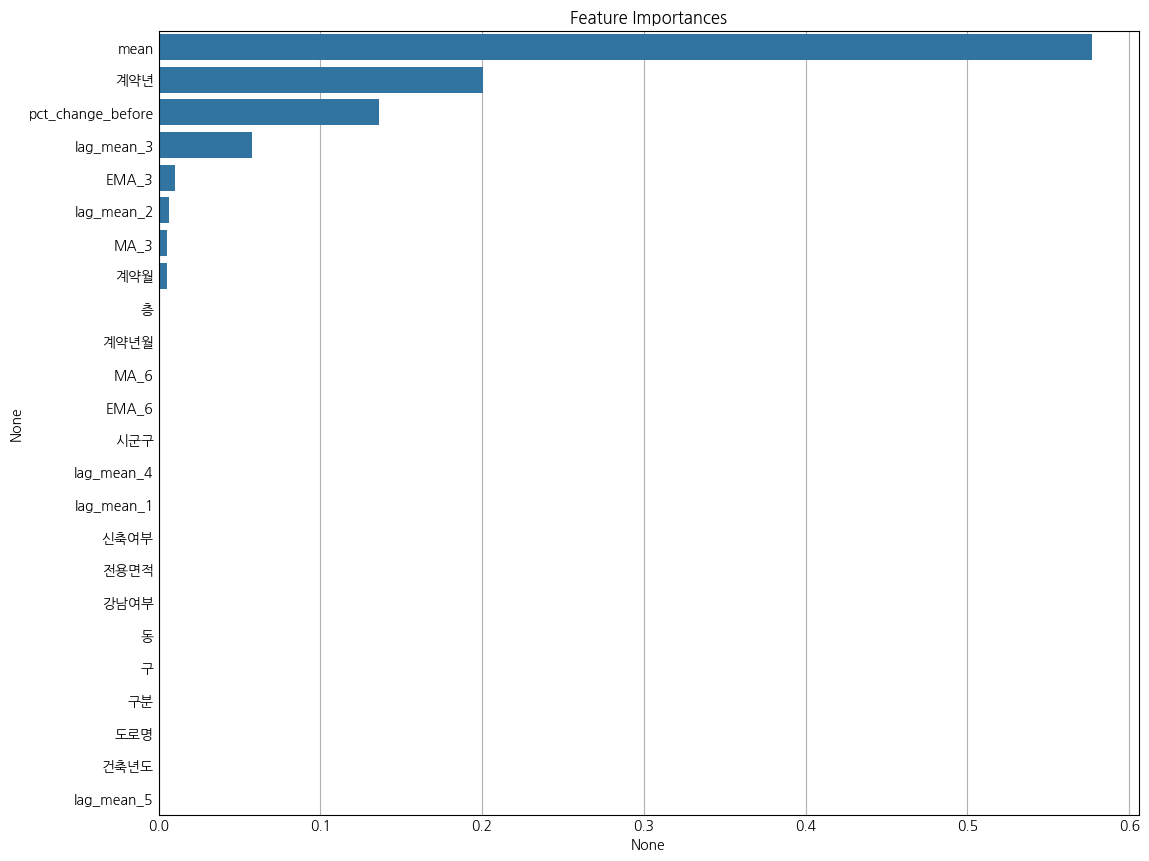

In [3154]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [3155]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [3156]:
%%time
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.   2분걸림
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = 'neg_mean_squared_error',        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

CPU times: user 463 ms, sys: 106 ms, total: 568 ms
Wall time: 1.2 s


Weight,Feature
2136020000.0000 ± 0.0000,mean
46524600.0000 ± 131591440.6080,계약년
16474533.3333 ± 23298508.4738,EMA_3
3573333.3333 ± 5053456.4629,계약월
1733333.3333 ± 2451303.5081,계약년월
0 ± 0.0000,건축년도
0 ± 0.0000,도로명
0 ± 0.0000,구분
0 ± 0.0000,구
0 ± 0.0000,동


- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [3157]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [3158]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [3159]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [3160]:
X_val_sort.head()

,시군구,전용면적,계약년월,층,건축년도,도로명,구분,구,동,계약년,계약월,강남여부,신축여부,mean,MA_3,MA_6,EMA_3,EMA_6,pct_change_before,lag_mean_1,lag_mean_2,lag_mean_3,lag_mean_4,lag_mean_5,target,pred,error
8,0,114.676,202006,21,2007,0,0,0,0,5,4,0,0,158000.0,120566.666667,107450.0,130067.96875,115478.341403,0.173959,110000.0,93700.0,99000.0,90000.0,94000.0,158000,127000.0,961000000.0
2,0,114.676,201504,4,2007,0,0,0,0,2,2,0,0,84500.0,90166.666667,107450.0,88750.00000,115478.341403,-0.102041,88000.0,98000.0,98000.0,98000.0,98000.0,84500,90800.0,39690000.0


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [3161]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [3162]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [3163]:
display(error_top100.head(1))
display(best_top100.head(1))

,시군구,전용면적,계약년월,층,건축년도,도로명,구분,구,동,계약년,계약월,강남여부,신축여부,mean,MA_3,MA_6,EMA_3,EMA_6,pct_change_before,lag_mean_1,lag_mean_2,lag_mean_3,lag_mean_4,lag_mean_5,target,pred,error
8,서울특별시 용산구 한강로1가,114.676,202006,21,2007,한강대로 211,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676,용산구,한강로1가,2020,06,0,0,158000.0,120566.666667,107450.0,130067.96875,115478.341403,0.173959,110000.0,93700.0,99000.0,90000.0,94000.0,158000,127000.0,961000000.0


,시군구,전용면적,계약년월,층,건축년도,도로명,구분,구,동,계약년,계약월,강남여부,신축여부,mean,MA_3,MA_6,EMA_3,EMA_6,pct_change_before,lag_mean_1,lag_mean_2,lag_mean_3,lag_mean_4,lag_mean_5,target,pred,error
8,서울특별시 용산구 한강로1가,114.676,202006,21,2007,한강대로 211,서울특별시 용산구 한강로1가 64 대우월드마크용산 114.676,용산구,한강로1가,2020,06,0,0,158000.0,120566.666667,107450.0,130067.96875,115478.341403,0.173959,110000.0,93700.0,99000.0,90000.0,94000.0,158000,127000.0,961000000.0


- 이제 분포를 비교해보도록 하겠습니다.

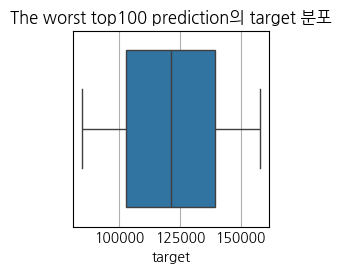

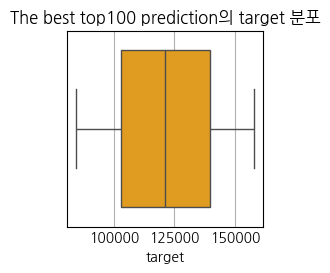

In [3164]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

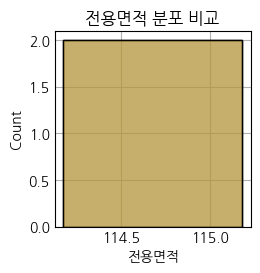

In [3165]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6 . Inference (추론)

In [3166]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,시군구,전용면적,계약년월,층,건축년도,도로명,target,구분,구,동,계약년,계약월,강남여부,신축여부,mean,MA_3,MA_6,EMA_3,EMA_6,pct_change_before,lag_mean_1,lag_mean_2,lag_mean_3,lag_mean_4,lag_mean_5


In [3167]:
dt_test

,시군구,전용면적,계약년월,층,건축년도,도로명,target,구분,구,동,계약년,계약월,강남여부,신축여부,mean,MA_3,MA_6,EMA_3,EMA_6,pct_change_before,lag_mean_1,lag_mean_2,lag_mean_3,lag_mean_4,lag_mean_5


In [3168]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [3169]:
X_test = dt_test.drop(['target'], axis=1)

In [3170]:
X_test.isna().sum()

시군구                  0.0
전용면적                 0.0
계약년월                 0.0
층                    0.0
건축년도                 0.0
도로명                  0.0
구분                   0.0
구                    0.0
동                    0.0
계약년                  0.0
계약월                  0.0
강남여부                 0.0
신축여부                 0.0
mean                 0.0
MA_3                 0.0
MA_6                 0.0
EMA_3                0.0
EMA_6                0.0
pct_change_before    0.0
lag_mean_1           0.0
lag_mean_2           0.0
lag_mean_3           0.0
lag_mean_4           0.0
lag_mean_5           0.0
dtype: float64

In [3171]:
%%time

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

ValueError: Found array with 0 sample(s) (shape=(0, 24)) while a minimum of 1 is required by RandomForestRegressor.

In [3172]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([27780.])

## 7 . Output File Save

In [3173]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)

In [3174]:
preds_df.to_csv('/content/drive/MyDrive/AILAB_Advance/output.csv', index=False)


# 기타 : 한글 다시 설치

In [3175]:
### 한글 다시 설치
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

# 출처: https://giveme-happyending.tistory.com/192 [소연의_개발일지:티스토리]

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache director